In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('D:/data6/deu-eng/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    print("len",len(lines))
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 6




def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
dic_subjects ={ "i" : "ich", "we" : "wir"}
dic_aux  ={ "want to" : "mochten", "can" : "konnen"}
dic_verbs  ={ "eat" : "essen", "drink" : "trinken","read":"lesen"}
dic_object_en  ={ "eat" : ["bread","apple"], "drink" : ["water","beer"],"read":["book","newspaper"]}
dic_object_ge  ={ "essen" : ["brot","apfel"], "trinken" : ["wasser","bier"],"lesen":["buch","zeitung"]}

In [8]:
import itertools

iterables_en = [ dic_subjects.keys(), dic_verbs.keys(), ["placeholder"]]

raw_english_simple = []
for t in itertools.product(*iterables_en):
    print( t ,"--",t[2])
    raw_english_simple.append(t)

('i', 'eat', 'placeholder') -- placeholder
('i', 'drink', 'placeholder') -- placeholder
('i', 'read', 'placeholder') -- placeholder
('we', 'eat', 'placeholder') -- placeholder
('we', 'drink', 'placeholder') -- placeholder
('we', 'read', 'placeholder') -- placeholder


In [9]:
import itertools

iterables_en = [ dic_subjects.keys(),  dic_aux.keys() ,dic_verbs.keys(), ["placeholder"]]

raw_english_aux = []
for t in itertools.product(*iterables_en):
    print( t ,"--",t[3])
    raw_english_aux.append(t)

('i', 'want to', 'eat', 'placeholder') -- placeholder
('i', 'want to', 'drink', 'placeholder') -- placeholder
('i', 'want to', 'read', 'placeholder') -- placeholder
('i', 'can', 'eat', 'placeholder') -- placeholder
('i', 'can', 'drink', 'placeholder') -- placeholder
('i', 'can', 'read', 'placeholder') -- placeholder
('we', 'want to', 'eat', 'placeholder') -- placeholder
('we', 'want to', 'drink', 'placeholder') -- placeholder
('we', 'want to', 'read', 'placeholder') -- placeholder
('we', 'can', 'eat', 'placeholder') -- placeholder
('we', 'can', 'drink', 'placeholder') -- placeholder
('we', 'can', 'read', 'placeholder') -- placeholder


In [10]:
final_sentences = []
for raw in raw_english_aux:
    verb = raw[2]
    verb_objects = dic_object_en[verb]
    for index,verb_object_en in enumerate(verb_objects):
        eng_sentence = [raw[0],raw[1],raw[2],verb_object_en]
        german_verb = dic_verbs[verb]
        verb_object_ge = dic_object_ge[german_verb][index]
        #word order is different in german
        german_sentence = [dic_subjects[raw[0]],dic_aux[raw[1]],verb_object_ge,german_verb]
        final_sentences.append([eng_sentence,german_sentence])

for raw in raw_english_simple:
    verb = raw[1]
    verb_objects = dic_object_en[verb]
    for verb_object in verb_objects:        
        eng_sentence = [raw[0],raw[1],verb_object]
        german_verb = dic_verbs[verb]
        verb_object_ge = dic_object_ge[german_verb][index]
        german_sentence = [dic_subjects[raw[0]],german_verb,verb_object_ge]
        final_sentences.append([eng_sentence,german_sentence])
        
final_sentences_pairs = []
for sentence_pair in final_sentences:
    en_sentence,ge_sentence = sentence_pair[0],sentence_pair[1]
    final_sentences_pairs.append([ " ".join(en_sentence)," ".join(ge_sentence) ])
final_sentences_pairs    

[['i want to eat bread', 'ich mochten brot essen'],
 ['i want to eat apple', 'ich mochten apfel essen'],
 ['i want to drink water', 'ich mochten wasser trinken'],
 ['i want to drink beer', 'ich mochten bier trinken'],
 ['i want to read book', 'ich mochten buch lesen'],
 ['i want to read newspaper', 'ich mochten zeitung lesen'],
 ['i can eat bread', 'ich konnen brot essen'],
 ['i can eat apple', 'ich konnen apfel essen'],
 ['i can drink water', 'ich konnen wasser trinken'],
 ['i can drink beer', 'ich konnen bier trinken'],
 ['i can read book', 'ich konnen buch lesen'],
 ['i can read newspaper', 'ich konnen zeitung lesen'],
 ['we want to eat bread', 'wir mochten brot essen'],
 ['we want to eat apple', 'wir mochten apfel essen'],
 ['we want to drink water', 'wir mochten wasser trinken'],
 ['we want to drink beer', 'wir mochten bier trinken'],
 ['we want to read book', 'wir mochten buch lesen'],
 ['we want to read newspaper', 'wir mochten zeitung lesen'],
 ['we can eat bread', 'wir konnen 

In [11]:
def readLangs(lang1, lang2,pair_sentences, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = pair_sentences
    print("len",len(lines))
    print("lines",lines[0])
    # Split every line into pairs and normalize
    pairs = [[normalizeString(l[0]),normalizeString(l[1])] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def prepareData(lang1, lang2,pair_sentences, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2,pair_sentences, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = pairs
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'deu',final_sentences_pairs, False)
print(random.choice(pairs))

Reading lines...
len 36
lines ['i want to eat bread', 'ich mochten brot essen']
Read 36 sentence pairs
Trimmed to 36 sentence pairs
Counting words...
Counted words:
eng 16
deu 15
['we want to eat bread', 'wir mochten brot essen']


In [12]:
pairs

[['i want to eat bread', 'ich mochten brot essen'],
 ['i want to eat apple', 'ich mochten apfel essen'],
 ['i want to drink water', 'ich mochten wasser trinken'],
 ['i want to drink beer', 'ich mochten bier trinken'],
 ['i want to read book', 'ich mochten buch lesen'],
 ['i want to read newspaper', 'ich mochten zeitung lesen'],
 ['i can eat bread', 'ich konnen brot essen'],
 ['i can eat apple', 'ich konnen apfel essen'],
 ['i can drink water', 'ich konnen wasser trinken'],
 ['i can drink beer', 'ich konnen bier trinken'],
 ['i can read book', 'ich konnen buch lesen'],
 ['i can read newspaper', 'ich konnen zeitung lesen'],
 ['we want to eat bread', 'wir mochten brot essen'],
 ['we want to eat apple', 'wir mochten apfel essen'],
 ['we want to drink water', 'wir mochten wasser trinken'],
 ['we want to drink beer', 'wir mochten bier trinken'],
 ['we want to read book', 'wir mochten buch lesen'],
 ['we want to read newspaper', 'wir mochten zeitung lesen'],
 ['we can eat bread', 'wir konnen 

In [13]:
print(random.choice(pairs))

['we eat apple', 'wir essen apfel']


In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
temp_map = {}
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    #input : decoder_input (input obtained at each step)    
    #hidden : decoder_hidden, value returned from this function is passed again
    #encoder_outputs : all outputs steps of encode,static in this function    
    def forward(self, input, hidden, encoder_outputs,is_appy_weight=True):
        temp_map["hidden_"] = hidden
        temp_map["input"] = input
        temp_map["encoder_outputs"] = encoder_outputs
        
        embedded = self.embedding(input).view(1, 1, -1)
        temp_map["embedded"] = embedded
        
        embedded = self.dropout(embedded)
        temp_map["embedded_dropout"] = embedded
        
        
        tensor_cat = torch.cat((embedded[0], hidden[0]), 1)
        temp_map["tensor_cat"] = tensor_cat
        
        attn_vector = self.attn(tensor_cat)
        temp_map["attn_vector"] = attn_vector
        
        attn_weights = F.softmax(attn_vector, dim=1)
        temp_map["attn_weights"] = attn_weights
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
        temp_map["attn_applied"] = attn_applied

        if is_appy_weight:
            output = torch.cat((embedded[0], attn_applied[0]), 1)
            temp_map["output"] = output
        else:
            output = torch.cat((embedded[0], embedded[0]), 1)
            temp_map["output"] = output
        
        output = self.attn_combine(output).unsqueeze(0)
        temp_map["output attn_combine"] = output

        output = F.relu(output)
        temp_map["output relu"] = output
        
        output_step, hidden_step = self.gru(output, hidden)
        temp_map["output_step"] = output_step
        temp_map["hidden_step"] = hidden_step

        output_softmax = F.log_softmax(self.out(output_step[0]), dim=1)
        temp_map["output_softmax"] = output_softmax
        
        return output_softmax, hidden_step, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [16]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [17]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if 3 < 2:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [18]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [19]:
import gc

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    gc.collect()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [21]:
evaluate_queue = []

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH,is_appy_weight=True):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        
        #evaluate_queue.append(["input_tensor",input_tensor])
        #evaluate_queue.append(["encoder_hidden",encoder_hidden])

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        #evaluate_queue.append(["encoder_outputs",encoder_outputs])

        for ei in range(input_length):
            #evaluate_queue.append(["input_tensor[ei]",input_tensor[ei]])
            #evaluate_queue.append(["encoder_hidden",encoder_hidden])
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            #evaluate_queue.append(["encoder_output",encoder_output])
            #evaluate_queue.append(["encoder_hidden",encoder_hidden])
            
            encoder_outputs[ei] += encoder_output[0, 0]
            #evaluate_queue.append(["encoder_outputs[ei]",encoder_outputs[ei]])

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        evaluate_queue.append(["decoder_input",decoder_input])

        decoder_hidden = encoder_hidden
        evaluate_queue.append(["encoder_hidden_decoder_hidden",decoder_hidden])

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            #print("di:",di)
            #return output_softmax, hidden_step, attn_weights
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs,is_appy_weight)
            evaluate_queue.append(["decoder_output",decoder_output])
            evaluate_queue.append(["decoder_hidden",decoder_hidden])
            evaluate_queue.append(["decoder_attention",decoder_attention])                        
            
            decoder_attentions[di] = decoder_attention.data
            evaluate_queue.append(["decoder_attentions[di]",decoder_attentions[di]])
            
            topv, topi = decoder_output.data.topk(1)
            evaluate_queue.append(["topv",topv])
            evaluate_queue.append(["topi",topi])
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                evaluate_queue.append(["output_lang.index2word[topi.item()]",output_lang.index2word[topi.item()]])
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
            evaluate_queue.append(["decoder_input",decoder_input])

        #print("returnin attention",decoder_attentions[:di + 1].shape)    
        evaluate_queue.append(["decoded_words",decoded_words])    
        return decoded_words, decoder_attentions[:di + 1]

In [22]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [23]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#trainIters(encoder1, attn_decoder1, 1000, print_every=500)

In [24]:
print( encoder1)

EncoderRNN(
  (embedding): Embedding(16, 256)
  (gru): GRU(256, 256)
)


In [25]:
print( attn_decoder1)

AttnDecoderRNN(
  (embedding): Embedding(15, 256)
  (attn): Linear(in_features=512, out_features=6, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=15, bias=True)
)


0m 11s (- 0m 11s) (500 50%) 0.0011
0m 22s (- 0m 0s) (1000 100%) 0.0010


<Figure size 432x288 with 0 Axes>

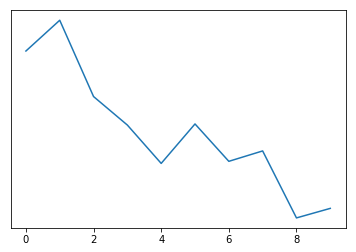

In [26]:
#1.3408
import os.path
decoder_path = "D:/data6/40iter_decoder"
encoder_path = "D:/data6/40iter_encoder"

for i in range(1):
    gc.collect()
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
    
    if os.path.isfile(decoder_path) :
        encoder1.load_state_dict(torch.load(encoder_path))
        attn_decoder1.load_state_dict(torch.load(decoder_path))
        
    trainIters(encoder1, attn_decoder1, 1000, print_every=500)
    torch.save(attn_decoder1.state_dict(), decoder_path)
    torch.save(encoder1.state_dict(), encoder_path)
        

In [27]:


#torch.save(attn_decoder1.state_dict(), "D:/data6/10iter_decoder")
#torch.save(encoder1.state_dict(), "D:/data6/10iter_encoder")
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval() 3.2



In [28]:
evaluateRandomly(encoder1, attn_decoder1)

> i read book
= ich lesen zeitung
< ich lesen zeitung <EOS>

> we want to read newspaper
= wir mochten zeitung lesen
< wir mochten zeitung lesen <EOS>

> i can eat apple
= ich konnen apfel essen
< ich konnen apfel essen <EOS>

> i drink beer
= ich trinken bier
< ich trinken bier <EOS>

> i can drink water
= ich konnen wasser trinken
< ich konnen wasser trinken <EOS>

> we drink water
= wir trinken bier
< wir trinken bier <EOS>

> we eat bread
= wir essen apfel
< wir essen apfel <EOS>

> we want to drink beer
= wir mochten bier trinken
< wir mochten bier trinken <EOS>

> i can eat bread
= ich konnen brot essen
< ich konnen brot essen <EOS>

> we want to drink beer
= wir mochten bier trinken
< wir mochten bier trinken <EOS>



<Figure size 432x288 with 0 Axes>

C:\Users\mcelikkaya\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


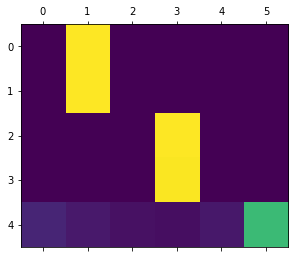

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [29]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "we can drink beer")
plt.matshow(attentions.numpy())
display(plt.figure())
plt.figure().show()

In [65]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence,is_appy_weight=True,dump_display=True):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence,is_appy_weight=is_appy_weight)
    
    if dump_display:
        print("Apply weight :",is_appy_weight)
        print('input =', input_sentence)
        print('output =', ' '.join(output_words))
        showAttention(input_sentence, output_words, attentions)
    return attentions,output_words

def get_eval_value(evaluate_queue,key):
    key_items = []
    for queue_item in evaluate_queue:
        if queue_item[0] == key:
            key_items.append( queue_item[1] )
    return key_items    

def draw_attention_map(key_items,output_words):
    key_values = [ np.exp( valcel ) for krow in key_items for valcel in krow.data.numpy().flatten()]
    key_values = [ np.exp( krow.data.numpy().flatten() ) for krow in key_items ]

    output_words[len(output_words)-1] = "EOS"
    output_words = [ str(index+1)+")"+ word for index,word in enumerate(output_words)]
    df2 = pd.DataFrame(key_values,columns=[i for i in output_lang.index2word.values()],index=output_words)
    cm = sns.light_palette("blue", as_cmap=True)

    s = df2.style.background_gradient(cmap=cm)
    return s

-------------------------------------------
Apply weight : True
input = i want to eat bread
output = ich mochten brot essen <EOS>


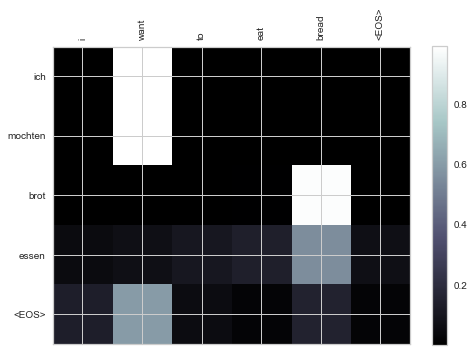

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999582,0.000060,0.000008,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004,0.000343
2)mochten,0.000001,0.000000,0.000042,0.999328,0.000136,0.000204,0.000000,0.000010,0.000044,0.000001,0.000000,0.000027,0.000000,0.000205,0.000002
3)brot,0.000014,0.000000,0.000043,0.000103,0.996638,0.000400,0.001381,0.000203,0.000000,0.000009,0.001145,0.000000,0.000040,0.000022,0.000001
4)essen,0.000003,0.000033,0.000010,0.000004,0.000237,0.999628,0.000009,0.000000,0.000008,0.000000,0.000001,0.000059,0.000001,0.000002,0.000003
5)EOS,0.000003,0.998949,0.000000,0.000000,0.000006,0.000121,0.000874,0.000001,0.000005,0.000009,0.000001,0.000007,0.000025,0.000000,0.000000


Apply weight : False
input = i want to eat bread
output = ich essen apfel <EOS>


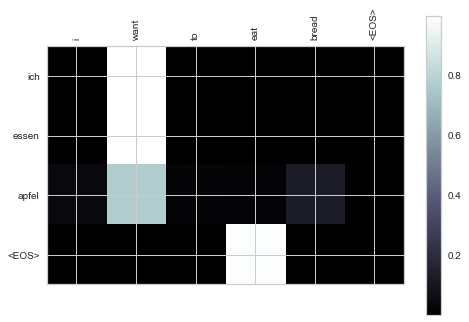

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000006,0.000000,0.740610,0.000173,0.000065,0.000052,0.000000,0.000003,0.000004,0.000000,0.000002,0.000001,0.000000,0.000096,0.258989
2)essen,0.000075,0.000000,0.000717,0.141104,0.009104,0.489032,0.000070,0.000110,0.006395,0.000015,0.000025,0.003110,0.000016,0.343267,0.006960
3)apfel,0.000080,0.000795,0.000004,0.000007,0.003246,0.000301,0.987940,0.000644,0.000045,0.002369,0.000171,0.000023,0.004329,0.000019,0.000027
4)EOS,0.000008,0.899362,0.000002,0.000000,0.000005,0.099131,0.000148,0.000000,0.000527,0.000004,0.000001,0.000785,0.000022,0.000001,0.000004


-------------------------------------------
Apply weight : True
input = i want to eat apple
output = ich mochten apfel essen <EOS>


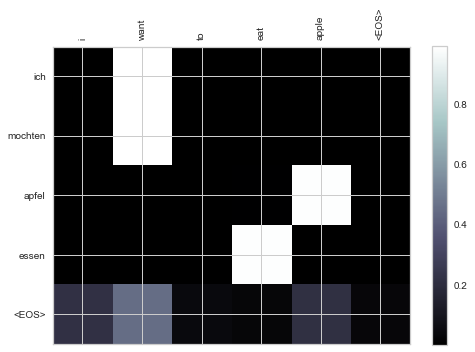

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999563,0.000032,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000400
2)mochten,0.000001,0.000000,0.000059,0.999243,0.000013,0.000244,0.000001,0.000003,0.000058,0.000003,0.000000,0.000027,0.000000,0.000343,0.000004
3)apfel,0.000003,0.000000,0.000002,0.000000,0.000616,0.000178,0.998787,0.000033,0.000000,0.000343,0.000010,0.000000,0.000027,0.000000,0.000000
4)essen,0.000000,0.000197,0.000001,0.000000,0.000002,0.999717,0.000053,0.000000,0.000014,0.000000,0.000000,0.000016,0.000000,0.000000,0.000000
5)EOS,0.000000,0.999534,0.000000,0.000000,0.000000,0.000013,0.000450,0.000000,0.000001,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i want to eat apple
output = ich essen apfel essen <EOS>


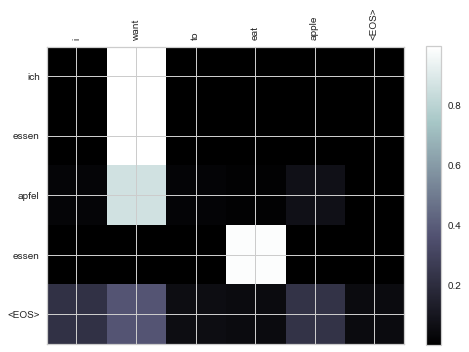

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000002,0.000000,0.926272,0.000060,0.000001,0.000023,0.000002,0.000001,0.000004,0.000000,0.000000,0.000000,0.000000,0.000031,0.073602
2)essen,0.000042,0.000000,0.000795,0.091561,0.000589,0.552484,0.000922,0.000025,0.007429,0.000061,0.000008,0.001766,0.000010,0.338672,0.005637
3)apfel,0.000012,0.000044,0.000001,0.000002,0.000124,0.000076,0.997078,0.000065,0.000012,0.001738,0.000025,0.000005,0.000807,0.000005,0.000005
4)essen,0.000021,0.314195,0.000010,0.000001,0.000009,0.680012,0.001317,0.000001,0.001993,0.000027,0.000001,0.002355,0.000042,0.000006,0.000009
5)EOS,0.000000,0.999855,0.000000,0.000000,0.000000,0.000002,0.000141,0.000000,0.000000,0.000001,0.000000,0.000000,0.000001,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i want to drink water
output = ich mochten wasser trinken <EOS>


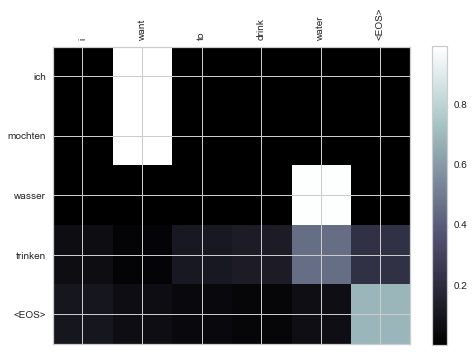

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999572,0.000071,0.000000,0.000000,0.000000,0.000002,0.000001,0.000000,0.000000,0.000000,0.000000,0.000002,0.000352
2)mochten,0.000001,0.000000,0.000042,0.999618,0.000005,0.000009,0.000000,0.000054,0.000115,0.000000,0.000001,0.000021,0.000000,0.000131,0.000003
3)wasser,0.000024,0.000000,0.000068,0.000082,0.000110,0.000000,0.000086,0.996733,0.000291,0.001368,0.001010,0.000001,0.000223,0.000002,0.000002
4)trinken,0.000003,0.000068,0.000022,0.000002,0.000000,0.000003,0.000000,0.000234,0.999641,0.000003,0.000000,0.000018,0.000002,0.000000,0.000002
5)EOS,0.000000,0.999869,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000119,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i want to drink water
output = ich mochten wasser trinken <EOS>


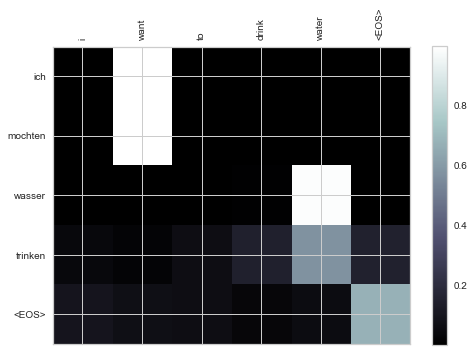

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000004,0.000000,0.717661,0.000182,0.000001,0.000001,0.000000,0.000030,0.000033,0.000000,0.000002,0.000001,0.000000,0.000033,0.282052
2)mochten,0.000116,0.000000,0.000760,0.588501,0.000532,0.018227,0.000032,0.002676,0.071242,0.000048,0.000076,0.003310,0.000010,0.305023,0.009447
3)wasser,0.000463,0.000006,0.000279,0.000094,0.059069,0.000075,0.043421,0.755655,0.000159,0.004989,0.117981,0.000029,0.017674,0.000081,0.000024
4)trinken,0.000093,0.002881,0.000216,0.000026,0.000015,0.001211,0.000024,0.001129,0.992881,0.000030,0.000049,0.001119,0.000141,0.000037,0.000148
5)EOS,0.000001,0.999823,0.000000,0.000000,0.000000,0.000001,0.000002,0.000000,0.000008,0.000162,0.000000,0.000001,0.000002,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i want to drink beer
output = ich mochten bier trinken <EOS>


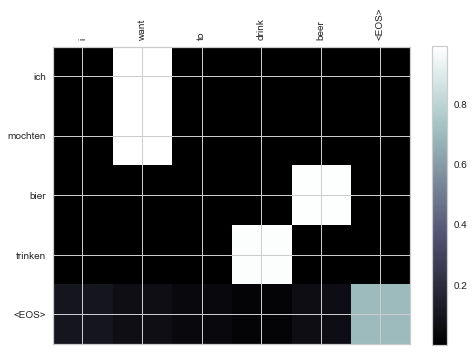

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000001,0.000000,0.999171,0.000195,0.000000,0.000000,0.000000,0.000000,0.000007,0.000001,0.000000,0.000000,0.000000,0.000009,0.000616
2)mochten,0.000001,0.000000,0.000022,0.999096,0.000003,0.000034,0.000000,0.000003,0.000548,0.000075,0.000000,0.000023,0.000000,0.000193,0.000002
3)bier,0.000002,0.000000,0.000000,0.000005,0.000001,0.000000,0.000240,0.001332,0.000282,0.998095,0.000000,0.000000,0.000041,0.000000,0.000000
4)trinken,0.000000,0.000553,0.000000,0.000000,0.000000,0.000002,0.000000,0.000001,0.999412,0.000029,0.000000,0.000003,0.000001,0.000000,0.000000
5)EOS,0.000000,0.999773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004,0.000222,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i want to drink beer
output = ich konnen bier trinken <EOS>


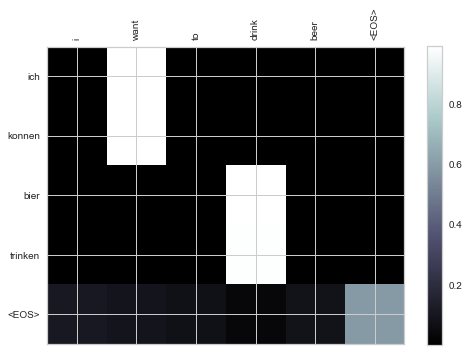

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000005,0.000000,0.746276,0.000209,0.000001,0.000004,0.000000,0.000002,0.000188,0.000015,0.000000,0.000001,0.000000,0.000110,0.253189
2)konnen,0.000121,0.000000,0.000643,0.288280,0.000302,0.126546,0.000237,0.000110,0.244207,0.004668,0.000007,0.005234,0.000043,0.317779,0.011822
3)bier,0.000192,0.000001,0.000093,0.001197,0.056413,0.001365,0.295253,0.011206,0.000435,0.629184,0.000929,0.000010,0.003513,0.000195,0.000014
4)trinken,0.000082,0.045614,0.000220,0.000020,0.000011,0.061919,0.000472,0.000030,0.889248,0.000254,0.000005,0.001903,0.000121,0.000004,0.000099
5)EOS,0.000000,0.999897,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000002,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i want to read book
output = ich mochten buch lesen <EOS>


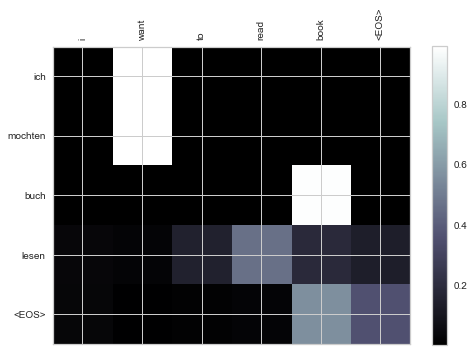

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999552,0.000073,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000012,0.000001,0.000000,0.000004,0.000358
2)mochten,0.000001,0.000000,0.000019,0.999669,0.000003,0.000004,0.000000,0.000011,0.000017,0.000000,0.000012,0.000121,0.000000,0.000142,0.000002
3)buch,0.000010,0.000000,0.000042,0.000012,0.001098,0.000000,0.000025,0.001274,0.000000,0.000001,0.996207,0.000248,0.001073,0.000011,0.000001
4)lesen,0.000001,0.000062,0.000001,0.000001,0.000000,0.000014,0.000000,0.000000,0.000007,0.000000,0.000160,0.999747,0.000004,0.000000,0.000003
5)EOS,0.000000,0.999703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000033,0.000263,0.000000,0.000000


Apply weight : False
input = i want to read book
output = ich konnen buch lesen <EOS>


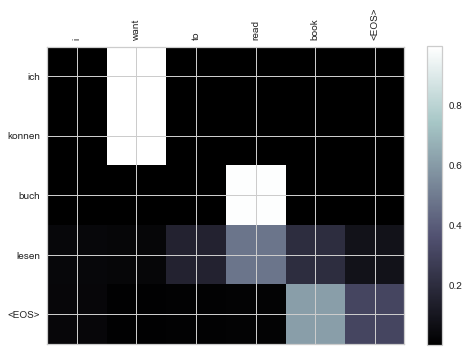

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000007,0.000000,0.849843,0.000327,0.000002,0.000001,0.000000,0.000008,0.000005,0.000000,0.000138,0.000020,0.000000,0.000145,0.149504
2)konnen,0.000123,0.000000,0.000781,0.226214,0.000414,0.016432,0.000026,0.000357,0.008625,0.000009,0.002277,0.073047,0.000071,0.660109,0.011515
3)buch,0.000528,0.000001,0.000120,0.001884,0.151093,0.000347,0.088964,0.161537,0.000065,0.005240,0.558590,0.000280,0.031001,0.000324,0.000024
4)lesen,0.000176,0.012298,0.000120,0.000080,0.000114,0.025309,0.000211,0.000115,0.001648,0.000023,0.002411,0.956804,0.000176,0.000014,0.000502
5)EOS,0.000003,0.998312,0.000000,0.000000,0.000001,0.000155,0.000013,0.000001,0.000027,0.000001,0.000006,0.000231,0.001247,0.000000,0.000002


-------------------------------------------
Apply weight : True
input = i want to read newspaper
output = ich mochten zeitung lesen <EOS>


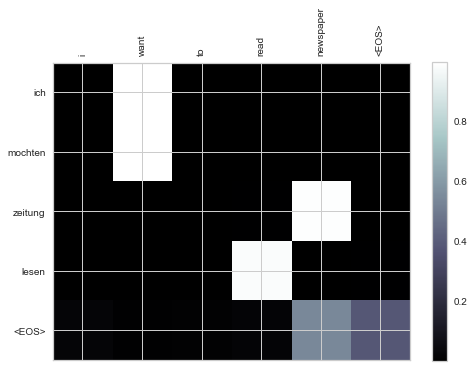

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999474,0.000050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000003,0.000470
2)mochten,0.000001,0.000000,0.000029,0.999265,0.000005,0.000015,0.000000,0.000004,0.000050,0.000002,0.000001,0.000357,0.000019,0.000250,0.000002
3)zeitung,0.000004,0.000001,0.000001,0.000003,0.000024,0.000000,0.000064,0.000323,0.000002,0.000117,0.001374,0.000354,0.997734,0.000001,0.000000
4)lesen,0.000000,0.000257,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000018,0.000000,0.000001,0.999657,0.000057,0.000000,0.000000
5)EOS,0.000000,0.999630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000362,0.000000,0.000000


Apply weight : False
input = i want to read newspaper
output = ich konnen zeitung essen <EOS>


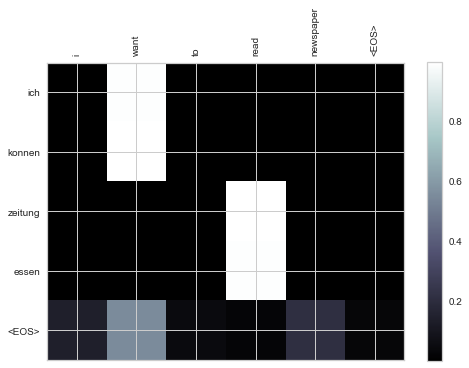

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000003,0.000000,0.897700,0.000187,0.000001,0.000001,0.000000,0.000001,0.000003,0.000000,0.000003,0.000020,0.000002,0.000093,0.101986
2)konnen,0.000098,0.000000,0.000754,0.365186,0.000356,0.055193,0.000064,0.000040,0.013719,0.000048,0.000049,0.102843,0.001896,0.447750,0.012004
3)zeitung,0.000428,0.000003,0.000114,0.001812,0.129970,0.000829,0.309934,0.019750,0.000093,0.036852,0.014176,0.000213,0.485620,0.000177,0.000031
4)essen,0.000135,0.206836,0.000024,0.000053,0.000095,0.474890,0.001345,0.000008,0.004302,0.000112,0.000036,0.310805,0.000401,0.000025,0.000932
5)EOS,0.000000,0.999865,0.000000,0.000000,0.000000,0.000002,0.000118,0.000000,0.000001,0.000002,0.000000,0.000004,0.000008,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i can eat bread
output = ich konnen brot essen <EOS>


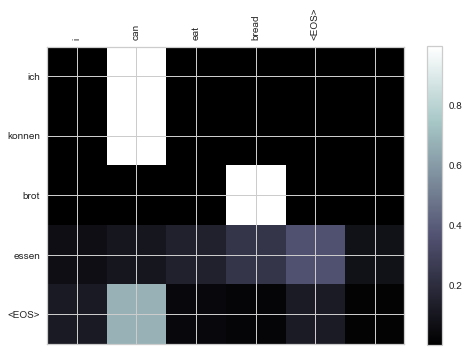

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999676,0.000000,0.000003,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000120,0.000199
2)konnen,0.000001,0.000000,0.000133,0.000158,0.000153,0.000249,0.000000,0.000001,0.000005,0.000000,0.000001,0.000008,0.000000,0.999286,0.000003
3)brot,0.000008,0.000000,0.000030,0.000014,0.997233,0.000187,0.001081,0.000143,0.000000,0.000007,0.000992,0.000000,0.000023,0.000281,0.000001
4)essen,0.000003,0.000033,0.000011,0.000001,0.000202,0.999646,0.000021,0.000000,0.000009,0.000000,0.000001,0.000060,0.000001,0.000009,0.000002
5)EOS,0.000001,0.998350,0.000000,0.000000,0.000003,0.000032,0.001592,0.000000,0.000001,0.000004,0.000001,0.000002,0.000014,0.000000,0.000000


Apply weight : False
input = i can eat bread
output = ich konnen brot essen <EOS>


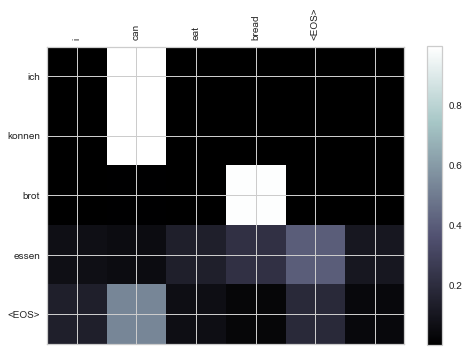

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000003,0.000000,0.922514,0.000066,0.000029,0.000036,0.000000,0.000001,0.000003,0.000000,0.000001,0.000001,0.000000,0.000045,0.077301
2)konnen,0.000074,0.000000,0.001094,0.113333,0.011536,0.307318,0.000054,0.000087,0.003752,0.000016,0.000026,0.002730,0.000018,0.556108,0.003854
3)brot,0.000095,0.000000,0.000067,0.000364,0.937328,0.002623,0.048384,0.005976,0.000009,0.002058,0.001804,0.000005,0.001161,0.000120,0.000006
4)essen,0.000019,0.000431,0.000017,0.000018,0.000389,0.998033,0.000094,0.000005,0.000389,0.000011,0.000006,0.000534,0.000020,0.000010,0.000025
5)EOS,0.000002,0.998906,0.000000,0.000000,0.000003,0.000119,0.000921,0.000001,0.000005,0.000012,0.000001,0.000006,0.000025,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i can eat apple
output = ich konnen apfel essen <EOS>


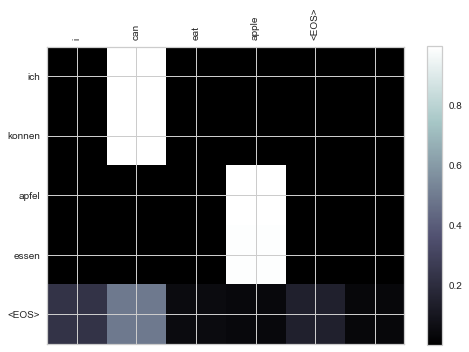

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999629,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000163,0.000205
2)konnen,0.000001,0.000000,0.000116,0.000154,0.000020,0.000494,0.000002,0.000001,0.000011,0.000000,0.000001,0.000015,0.000000,0.999182,0.000003
3)apfel,0.000002,0.000000,0.000003,0.000000,0.001457,0.000319,0.997712,0.000033,0.000000,0.000430,0.000012,0.000000,0.000027,0.000004,0.000000
4)essen,0.000001,0.001312,0.000001,0.000000,0.000003,0.998356,0.000298,0.000000,0.000016,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000
5)EOS,0.000000,0.999769,0.000000,0.000000,0.000000,0.000003,0.000228,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i can eat apple
output = ich essen apfel essen <EOS>


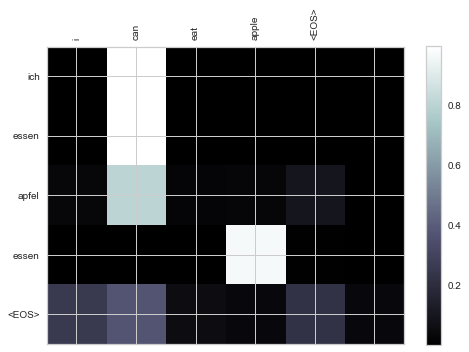

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000002,0.000000,0.910233,0.000048,0.000002,0.000046,0.000002,0.000000,0.000005,0.000000,0.000000,0.000001,0.000000,0.000064,0.089599
2)essen,0.000040,0.000000,0.000472,0.041002,0.000494,0.597041,0.001005,0.000019,0.012548,0.000075,0.000007,0.002961,0.000024,0.339717,0.004594
3)apfel,0.000008,0.000141,0.000000,0.000001,0.000057,0.000050,0.997450,0.000031,0.000012,0.001448,0.000013,0.000004,0.000777,0.000003,0.000003
4)essen,0.000016,0.418061,0.000004,0.000001,0.000008,0.577056,0.001336,0.000001,0.001656,0.000027,0.000001,0.001783,0.000029,0.000004,0.000018
5)EOS,0.000000,0.999879,0.000000,0.000000,0.000000,0.000002,0.000116,0.000000,0.000000,0.000001,0.000000,0.000000,0.000001,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i can drink water
output = ich konnen wasser trinken <EOS>


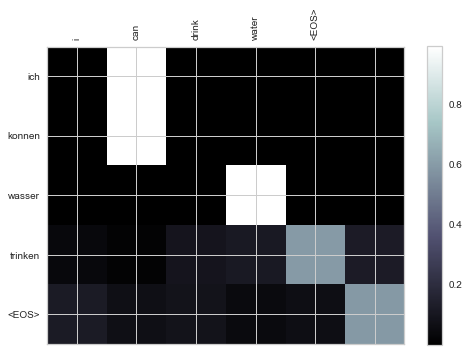

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999688,0.000001,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000068,0.000242
2)konnen,0.000001,0.000000,0.000171,0.000373,0.000014,0.000031,0.000000,0.000029,0.000057,0.000000,0.000007,0.000021,0.000000,0.999292,0.000005
3)wasser,0.000021,0.000000,0.000052,0.000040,0.000138,0.000000,0.000071,0.995505,0.000644,0.002206,0.000926,0.000001,0.000332,0.000063,0.000001
4)trinken,0.000002,0.000107,0.000017,0.000000,0.000000,0.000004,0.000000,0.000147,0.999701,0.000003,0.000000,0.000012,0.000003,0.000001,0.000001
5)EOS,0.000001,0.999480,0.000000,0.000000,0.000000,0.000000,0.000002,0.000002,0.000054,0.000458,0.000000,0.000001,0.000002,0.000000,0.000000


Apply weight : False
input = i can drink water
output = ich konnen apfel essen <EOS>


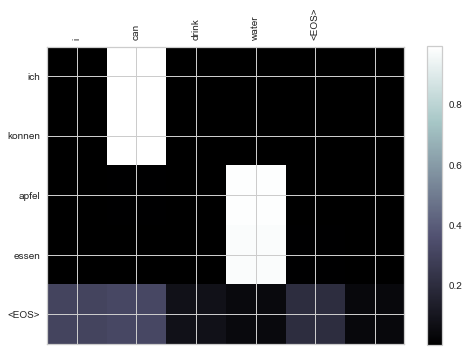

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000002,0.000000,0.932015,0.000105,0.000000,0.000000,0.000000,0.000016,0.000023,0.000000,0.000002,0.000001,0.000000,0.000037,0.067798
2)konnen,0.000123,0.000000,0.001139,0.337893,0.000564,0.041101,0.000037,0.001898,0.113070,0.000047,0.000072,0.007370,0.000019,0.487306,0.009362
3)apfel,0.000484,0.000002,0.000150,0.000463,0.325918,0.001122,0.390472,0.226987,0.000095,0.008881,0.039742,0.000020,0.005357,0.000255,0.000052
4)essen,0.000037,0.004862,0.000044,0.000008,0.000094,0.989799,0.000145,0.000020,0.002637,0.000006,0.000017,0.002288,0.000019,0.000012,0.000011
5)EOS,0.000000,0.999767,0.000000,0.000000,0.000000,0.000014,0.000209,0.000000,0.000002,0.000002,0.000000,0.000002,0.000003,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i can drink beer
output = ich konnen bier trinken <EOS>


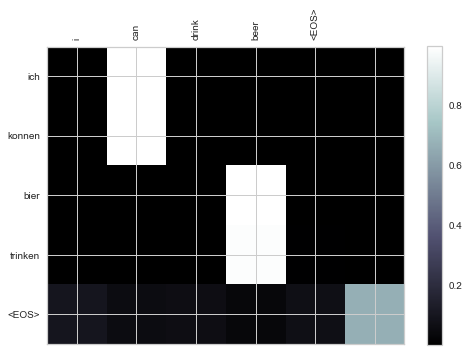

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000138,0.000436
2)konnen,0.000001,0.000000,0.000140,0.000220,0.000006,0.000063,0.000000,0.000001,0.000081,0.000008,0.000000,0.000012,0.000000,0.999462,0.000003
3)bier,0.000001,0.000000,0.000000,0.000002,0.000003,0.000000,0.000292,0.001156,0.000252,0.998224,0.000000,0.000000,0.000068,0.000001,0.000000
4)trinken,0.000001,0.001189,0.000001,0.000000,0.000000,0.000006,0.000001,0.000002,0.998590,0.000207,0.000000,0.000002,0.000001,0.000000,0.000000
5)EOS,0.000000,0.999108,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000018,0.000872,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i can drink beer
output = ich konnen apfel essen <EOS>


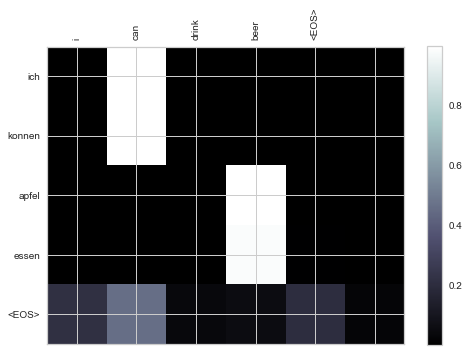

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000003,0.000000,0.867125,0.000074,0.000000,0.000008,0.000000,0.000000,0.000097,0.000007,0.000000,0.000001,0.000000,0.000125,0.132559
2)konnen,0.000078,0.000000,0.000924,0.089736,0.000222,0.192593,0.000156,0.000044,0.172829,0.001845,0.000004,0.004120,0.000030,0.531567,0.005851
3)apfel,0.000196,0.000002,0.000056,0.000248,0.064886,0.001466,0.479236,0.007920,0.000184,0.440412,0.000974,0.000006,0.004287,0.000116,0.000012
4)essen,0.000010,0.008936,0.000011,0.000002,0.000010,0.987472,0.000127,0.000001,0.002821,0.000044,0.000000,0.000553,0.000007,0.000003,0.000004
5)EOS,0.000000,0.999539,0.000000,0.000000,0.000000,0.000013,0.000432,0.000000,0.000003,0.000010,0.000000,0.000000,0.000002,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i can read book
output = ich konnen buch lesen <EOS>


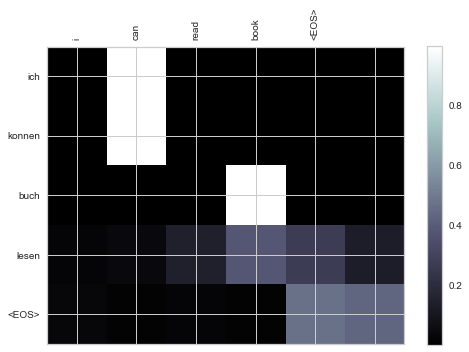

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999488,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000017,0.000001,0.000000,0.000169,0.000325
2)konnen,0.000001,0.000000,0.000107,0.000283,0.000011,0.000008,0.000000,0.000005,0.000004,0.000000,0.000097,0.000087,0.000000,0.999392,0.000003
3)buch,0.000007,0.000000,0.000050,0.000002,0.001177,0.000000,0.000026,0.001031,0.000000,0.000001,0.996071,0.000216,0.001300,0.000116,0.000001
4)lesen,0.000002,0.000080,0.000004,0.000000,0.000001,0.000032,0.000000,0.000001,0.000005,0.000000,0.000757,0.999102,0.000010,0.000001,0.000005
5)EOS,0.000000,0.999065,0.000000,0.000000,0.000000,0.000001,0.000001,0.000000,0.000002,0.000000,0.000003,0.000055,0.000873,0.000000,0.000000


Apply weight : False
input = i can read book
output = ich konnen buch lesen <EOS>


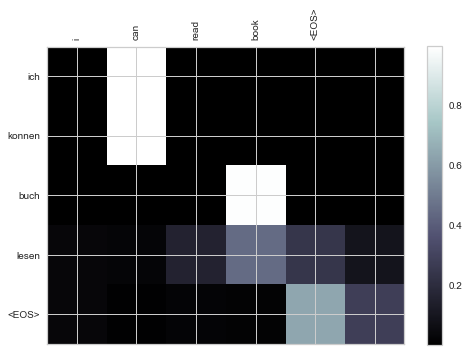

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000003,0.000000,0.956929,0.000054,0.000001,0.000001,0.000000,0.000003,0.000001,0.000000,0.000084,0.000009,0.000000,0.000046,0.042871
2)konnen,0.000138,0.000000,0.001648,0.338149,0.000698,0.019308,0.000027,0.000363,0.006698,0.000009,0.002570,0.073287,0.000084,0.547390,0.009632
3)buch,0.000703,0.000002,0.000124,0.001825,0.201375,0.000465,0.113243,0.149645,0.000065,0.009326,0.483413,0.000298,0.039261,0.000226,0.000031
4)lesen,0.000161,0.008731,0.000109,0.000115,0.000112,0.027991,0.000127,0.000105,0.002396,0.000022,0.001618,0.957858,0.000151,0.000015,0.000490
5)EOS,0.000003,0.998296,0.000000,0.000000,0.000001,0.000126,0.000009,0.000001,0.000035,0.000001,0.000005,0.000241,0.001280,0.000000,0.000002


-------------------------------------------
Apply weight : True
input = i can read newspaper
output = ich konnen zeitung lesen <EOS>


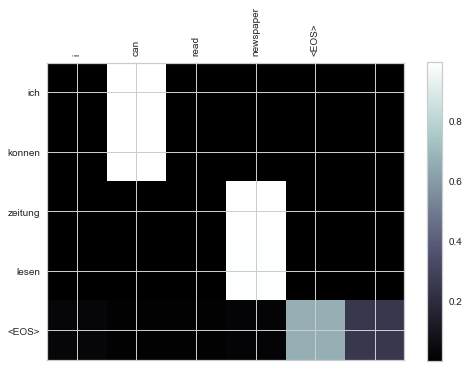

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999590,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000001,0.000000,0.000143,0.000264
2)konnen,0.000001,0.000000,0.000076,0.000187,0.000007,0.000025,0.000000,0.000001,0.000012,0.000000,0.000002,0.000111,0.000017,0.999560,0.000002
3)zeitung,0.000003,0.000000,0.000001,0.000001,0.000034,0.000000,0.000057,0.000248,0.000003,0.000107,0.001404,0.000473,0.997656,0.000012,0.000000
4)lesen,0.000000,0.000402,0.000000,0.000000,0.000000,0.000016,0.000000,0.000000,0.000048,0.000000,0.000001,0.999406,0.000125,0.000000,0.000000
5)EOS,0.000000,0.999786,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000211,0.000000,0.000000


Apply weight : False
input = i can read newspaper
output = ich konnen zeitung essen <EOS>


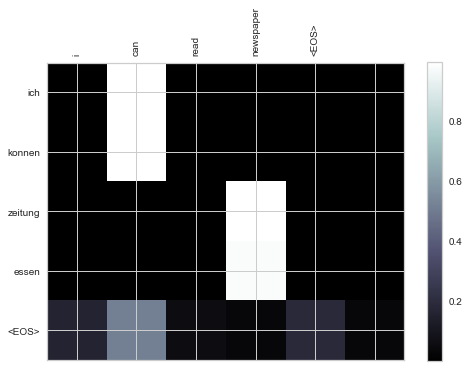

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000003,0.000000,0.821823,0.000055,0.000001,0.000002,0.000000,0.000000,0.000006,0.000000,0.000002,0.000025,0.000002,0.000066,0.178015
2)konnen,0.000103,0.000000,0.001061,0.131930,0.000517,0.063584,0.000090,0.000034,0.007574,0.000054,0.000071,0.113509,0.002298,0.668015,0.011161
3)zeitung,0.000320,0.000005,0.000094,0.000632,0.066264,0.001436,0.414938,0.008443,0.000101,0.029128,0.008567,0.000239,0.469585,0.000229,0.000020
4)essen,0.000174,0.158568,0.000030,0.000078,0.000200,0.518078,0.002331,0.000011,0.003052,0.000223,0.000059,0.314962,0.000554,0.000047,0.001630
5)EOS,0.000000,0.999785,0.000000,0.000000,0.000000,0.000004,0.000193,0.000000,0.000001,0.000003,0.000000,0.000005,0.000009,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we want to eat bread
output = wir mochten brot essen <EOS>


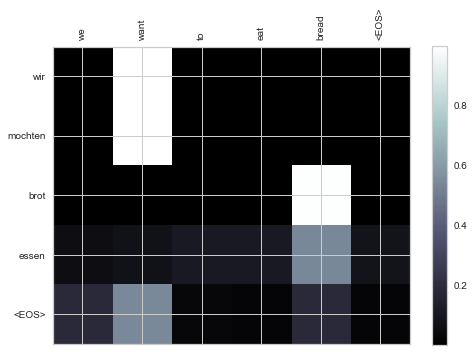

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000276,0.000111,0.000008,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.999595
2)mochten,0.000001,0.000000,0.000001,0.999364,0.000124,0.000218,0.000000,0.000006,0.000041,0.000001,0.000000,0.000041,0.000000,0.000159,0.000044
3)brot,0.000012,0.000000,0.000003,0.000129,0.997224,0.000291,0.000847,0.000172,0.000000,0.000007,0.001237,0.000000,0.000046,0.000015,0.000016
4)essen,0.000004,0.000052,0.000001,0.000008,0.000454,0.999259,0.000009,0.000000,0.000008,0.000000,0.000002,0.000144,0.000002,0.000002,0.000055
5)EOS,0.000001,0.999449,0.000000,0.000000,0.000003,0.000057,0.000459,0.000001,0.000003,0.000005,0.000001,0.000004,0.000016,0.000000,0.000002


Apply weight : False
input = we want to eat bread
output = wir mochten brot essen <EOS>


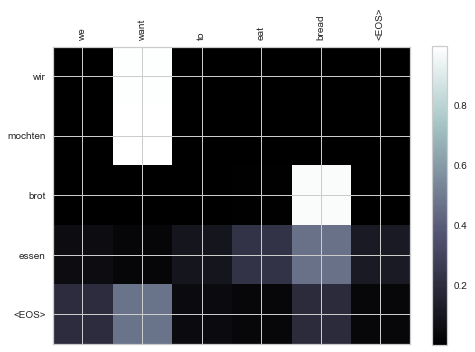

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000003,0.000000,0.025760,0.000120,0.000045,0.000037,0.000000,0.000001,0.000002,0.000000,0.000001,0.000001,0.000000,0.000064,0.973965
2)mochten,0.000110,0.000000,0.000633,0.738917,0.004815,0.009401,0.000019,0.001179,0.012892,0.000120,0.000073,0.002238,0.000037,0.228710,0.000854
3)brot,0.000759,0.000005,0.000196,0.000257,0.592573,0.000144,0.041591,0.251361,0.000085,0.016100,0.046629,0.000019,0.050077,0.000166,0.000039
4)essen,0.000122,0.021609,0.000046,0.000027,0.000510,0.970601,0.000165,0.000036,0.002517,0.000042,0.000052,0.003863,0.000280,0.000019,0.000112
5)EOS,0.000000,0.999885,0.000000,0.000000,0.000000,0.000006,0.000102,0.000000,0.000001,0.000002,0.000000,0.000001,0.000004,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we want to eat apple
output = wir mochten apfel essen <EOS>


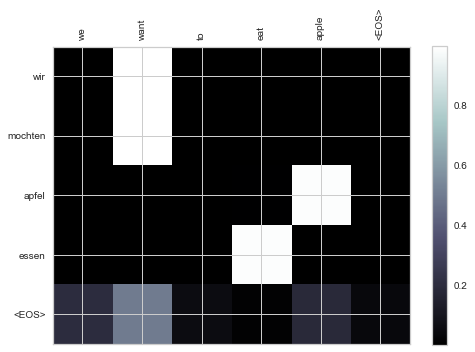

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000287,0.000075,0.000000,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.999628
2)mochten,0.000001,0.000000,0.000002,0.998920,0.000014,0.000463,0.000002,0.000003,0.000107,0.000004,0.000000,0.000059,0.000000,0.000313,0.000110
3)apfel,0.000003,0.000001,0.000000,0.000001,0.000656,0.000215,0.998608,0.000034,0.000000,0.000435,0.000011,0.000000,0.000036,0.000000,0.000001
4)essen,0.000001,0.000687,0.000000,0.000000,0.000003,0.999172,0.000083,0.000000,0.000023,0.000000,0.000000,0.000029,0.000000,0.000000,0.000003
5)EOS,0.000000,0.999867,0.000000,0.000000,0.000000,0.000010,0.000121,0.000000,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = we want to eat apple
output = wir mochten apfel essen <EOS>


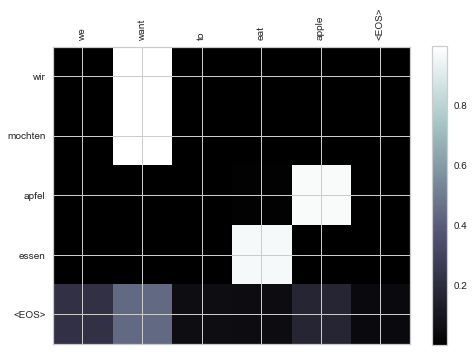

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000003,0.000000,0.104765,0.000138,0.000003,0.000032,0.000005,0.000001,0.000006,0.000000,0.000001,0.000001,0.000000,0.000056,0.894989
2)mochten,0.000086,0.000000,0.000416,0.777665,0.000201,0.021333,0.000510,0.000488,0.085814,0.001051,0.000024,0.003360,0.000055,0.108224,0.000773
3)apfel,0.000446,0.000002,0.000074,0.000199,0.105910,0.000453,0.695314,0.060141,0.000092,0.040591,0.031339,0.000023,0.065232,0.000132,0.000052
4)essen,0.000030,0.013625,0.000013,0.000004,0.000031,0.979788,0.000389,0.000004,0.003704,0.000025,0.000005,0.002303,0.000052,0.000006,0.000022
5)EOS,0.000000,0.999758,0.000000,0.000000,0.000000,0.000007,0.000229,0.000000,0.000001,0.000002,0.000000,0.000001,0.000003,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we want to drink water
output = wir mochten wasser trinken <EOS>


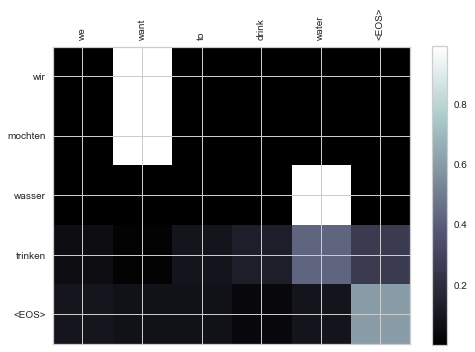

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000232,0.000215,0.000000,0.000000,0.000000,0.000002,0.000003,0.000000,0.000000,0.000000,0.000000,0.000001,0.999546
2)mochten,0.000001,0.000000,0.000001,0.999600,0.000004,0.000011,0.000000,0.000048,0.000172,0.000001,0.000001,0.000035,0.000000,0.000086,0.000040
3)wasser,0.000021,0.000000,0.000001,0.000066,0.000116,0.000000,0.000086,0.996157,0.000170,0.002170,0.000855,0.000001,0.000347,0.000001,0.000008
4)trinken,0.000004,0.000246,0.000002,0.000002,0.000000,0.000005,0.000000,0.000268,0.999413,0.000005,0.000000,0.000037,0.000005,0.000000,0.000013
5)EOS,0.000000,0.999915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000075,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = we want to drink water
output = wir mochten wasser trinken <EOS>


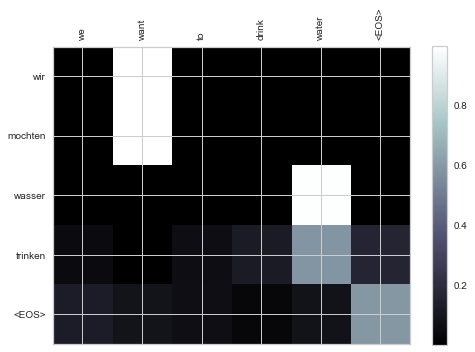

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000003,0.000000,0.059744,0.000187,0.000001,0.000001,0.000000,0.000030,0.000023,0.000000,0.000002,0.000001,0.000000,0.000018,0.939992
2)mochten,0.000074,0.000000,0.000343,0.788337,0.000093,0.000460,0.000006,0.011922,0.139587,0.000156,0.000093,0.002768,0.000017,0.055537,0.000607
3)wasser,0.000203,0.000001,0.000033,0.000084,0.011620,0.000004,0.006771,0.923400,0.000101,0.005120,0.043632,0.000006,0.008997,0.000019,0.000010
4)trinken,0.000132,0.001943,0.000177,0.000049,0.000018,0.000602,0.000019,0.002378,0.993199,0.000049,0.000072,0.000976,0.000186,0.000026,0.000173
5)EOS,0.000001,0.999707,0.000000,0.000000,0.000000,0.000001,0.000003,0.000001,0.000012,0.000271,0.000000,0.000001,0.000003,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we want to drink beer
output = wir mochten bier trinken <EOS>


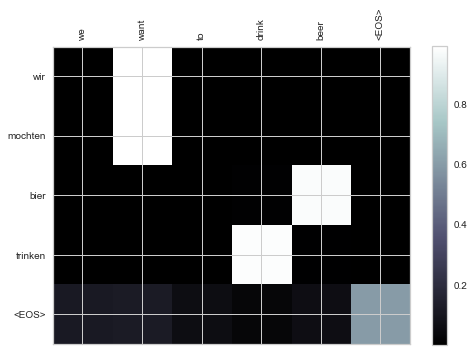

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000382,0.000104,0.000000,0.000000,0.000000,0.000000,0.000006,0.000001,0.000000,0.000000,0.000000,0.000002,0.999504
2)mochten,0.000001,0.000000,0.000002,0.998396,0.000004,0.000053,0.000000,0.000005,0.001057,0.000105,0.000000,0.000039,0.000000,0.000259,0.000078
3)bier,0.000002,0.000000,0.000000,0.000012,0.000002,0.000000,0.000255,0.002066,0.000647,0.996959,0.000000,0.000000,0.000056,0.000000,0.000001
4)trinken,0.000000,0.000264,0.000000,0.000000,0.000000,0.000002,0.000000,0.000002,0.999694,0.000033,0.000000,0.000004,0.000001,0.000000,0.000001
5)EOS,0.000000,0.999628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000362,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = we want to drink beer
output = wir trinken bier <EOS>


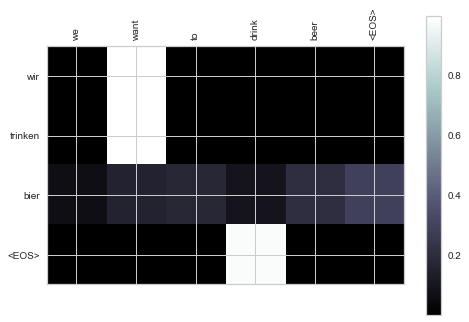

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000002,0.000000,0.065625,0.000074,0.000000,0.000002,0.000000,0.000001,0.000049,0.000008,0.000000,0.000000,0.000000,0.000042,0.934195
2)trinken,0.000052,0.000000,0.000210,0.442070,0.000020,0.001082,0.000020,0.000395,0.503330,0.022245,0.000003,0.001684,0.000026,0.028480,0.000384
3)bier,0.000002,0.000033,0.000000,0.000008,0.000001,0.000001,0.000092,0.000009,0.000008,0.999817,0.000000,0.000000,0.000027,0.000001,0.000000
4)EOS,0.000024,0.861431,0.000011,0.000004,0.000000,0.001772,0.000067,0.000004,0.135427,0.000840,0.000000,0.000359,0.000034,0.000001,0.000026


-------------------------------------------
Apply weight : True
input = we want to read book
output = wir mochten buch lesen <EOS>


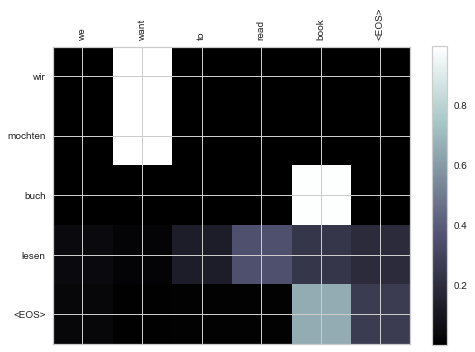

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000001,0.000000,0.000318,0.000181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000005,0.000000,0.000002,0.999484
2)mochten,0.000001,0.000000,0.000001,0.999536,0.000005,0.000010,0.000000,0.000009,0.000019,0.000000,0.000015,0.000235,0.000000,0.000132,0.000037
3)buch,0.000008,0.000000,0.000002,0.000004,0.000930,0.000000,0.000038,0.000725,0.000000,0.000001,0.996247,0.000236,0.001801,0.000004,0.000006
4)lesen,0.000001,0.000288,0.000000,0.000001,0.000000,0.000021,0.000000,0.000001,0.000008,0.000000,0.000297,0.999355,0.000008,0.000000,0.000020
5)EOS,0.000000,0.999683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000002,0.000069,0.000244,0.000000,0.000000


Apply weight : False
input = we want to read book
output = wir mochten buch lesen <EOS>


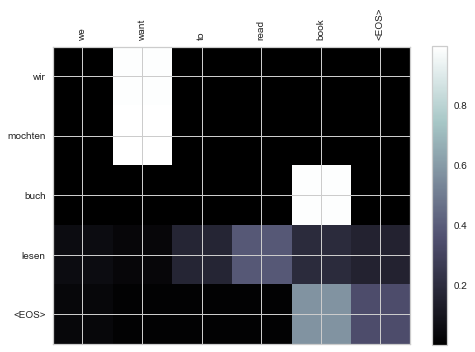

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000004,0.000000,0.033317,0.000149,0.000001,0.000001,0.000000,0.000006,0.000003,0.000000,0.000102,0.000022,0.000000,0.000022,0.966374
2)mochten,0.000105,0.000000,0.000401,0.842224,0.000074,0.000303,0.000004,0.003637,0.039138,0.000062,0.002091,0.038063,0.000140,0.073332,0.000427
3)buch,0.000288,0.000002,0.000041,0.000058,0.013188,0.000006,0.007420,0.222081,0.000028,0.001482,0.705366,0.000051,0.049943,0.000030,0.000015
4)lesen,0.000239,0.067677,0.000086,0.000032,0.000048,0.010567,0.000076,0.000143,0.002966,0.000022,0.002056,0.915045,0.000234,0.000009,0.000799
5)EOS,0.000001,0.999592,0.000000,0.000000,0.000000,0.000022,0.000002,0.000000,0.000009,0.000000,0.000001,0.000061,0.000311,0.000000,0.000001


-------------------------------------------
Apply weight : True
input = we want to read newspaper
output = wir mochten zeitung lesen <EOS>


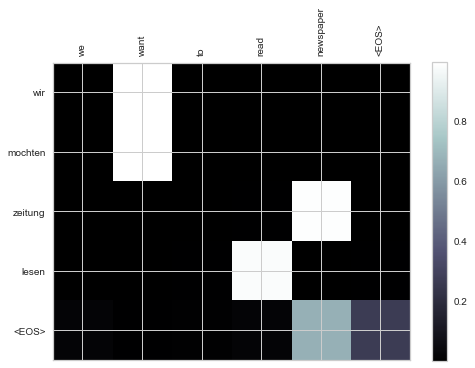

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000001,0.000000,0.000485,0.000203,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000010,0.000000,0.000003,0.999297
2)mochten,0.000001,0.000000,0.000001,0.999124,0.000005,0.000023,0.000000,0.000003,0.000083,0.000002,0.000001,0.000528,0.000015,0.000180,0.000036
3)zeitung,0.000003,0.000001,0.000000,0.000005,0.000020,0.000000,0.000051,0.000150,0.000003,0.000090,0.000746,0.000903,0.998025,0.000001,0.000000
4)lesen,0.000000,0.000402,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000021,0.000000,0.000001,0.999521,0.000041,0.000000,0.000001
5)EOS,0.000000,0.999620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000016,0.000363,0.000000,0.000000


Apply weight : False
input = we want to read newspaper
output = wir mochten zeitung <EOS>


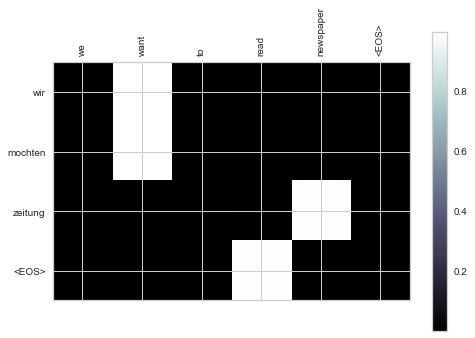

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000004,0.000000,0.134226,0.000115,0.000001,0.000001,0.000000,0.000001,0.000004,0.000000,0.000003,0.000018,0.000003,0.000055,0.865567
2)mochten,0.000107,0.000000,0.000593,0.684632,0.000078,0.001349,0.000019,0.000511,0.076800,0.000540,0.000076,0.066434,0.004936,0.163398,0.000528
3)zeitung,0.000157,0.000005,0.000022,0.000031,0.009296,0.000017,0.052016,0.018824,0.000041,0.011960,0.015226,0.000052,0.892324,0.000023,0.000005
4)EOS,0.000335,0.435482,0.000043,0.000079,0.000134,0.179353,0.001243,0.000046,0.013932,0.000320,0.000111,0.365918,0.001492,0.000047,0.001466


-------------------------------------------
Apply weight : True
input = we can eat bread
output = wir konnen brot essen <EOS>


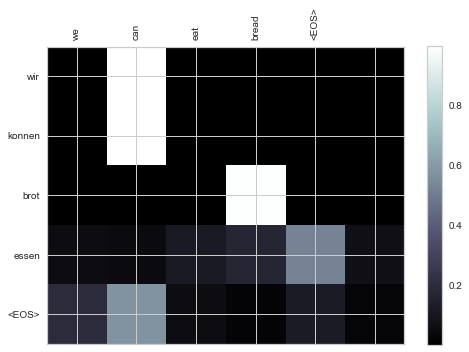

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000327,0.000001,0.000004,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000094,0.999570
2)konnen,0.000001,0.000000,0.000008,0.000161,0.000249,0.000311,0.000000,0.000002,0.000006,0.000000,0.000003,0.000015,0.000000,0.999136,0.000106
3)brot,0.000007,0.000000,0.000001,0.000012,0.997700,0.000130,0.000871,0.000120,0.000000,0.000005,0.000992,0.000000,0.000022,0.000133,0.000007
4)essen,0.000003,0.000215,0.000001,0.000000,0.000174,0.999485,0.000018,0.000000,0.000006,0.000000,0.000001,0.000072,0.000002,0.000003,0.000021
5)EOS,0.000000,0.999744,0.000000,0.000000,0.000000,0.000013,0.000238,0.000000,0.000000,0.000001,0.000000,0.000000,0.000003,0.000000,0.000000


Apply weight : False
input = we can eat bread
output = wir mochten brot essen <EOS>


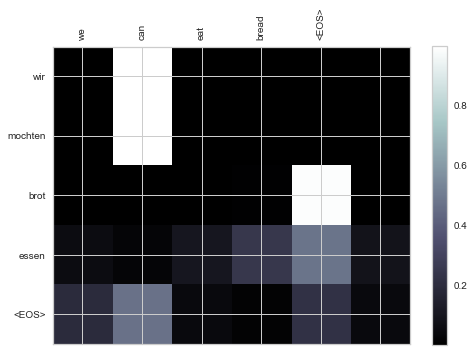

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000002,0.000000,0.012258,0.000031,0.000017,0.000022,0.000000,0.000001,0.000003,0.000000,0.000000,0.000001,0.000000,0.000031,0.987634
2)mochten,0.000153,0.000000,0.000627,0.623149,0.002244,0.023278,0.000033,0.001895,0.147600,0.000455,0.000043,0.008025,0.000112,0.191448,0.000937
3)brot,0.000676,0.000019,0.000098,0.000093,0.664464,0.000497,0.075924,0.121402,0.000080,0.011518,0.048351,0.000034,0.076727,0.000094,0.000021
4)essen,0.000125,0.033949,0.000037,0.000018,0.000555,0.955762,0.000182,0.000034,0.002914,0.000045,0.000069,0.005736,0.000429,0.000020,0.000124
5)EOS,0.000000,0.999924,0.000000,0.000000,0.000000,0.000005,0.000060,0.000000,0.000001,0.000002,0.000000,0.000001,0.000006,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we can eat apple
output = wir konnen apfel essen <EOS>


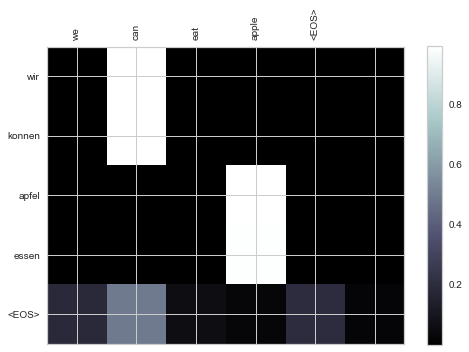

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000318,0.000001,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000062,0.999615
2)konnen,0.000001,0.000000,0.000004,0.000133,0.000022,0.000470,0.000006,0.000001,0.000013,0.000000,0.000001,0.000016,0.000000,0.999239,0.000094
3)apfel,0.000002,0.000000,0.000000,0.000000,0.000769,0.000263,0.998691,0.000024,0.000000,0.000215,0.000009,0.000000,0.000024,0.000002,0.000001
4)essen,0.000001,0.001055,0.000000,0.000000,0.000003,0.998610,0.000304,0.000000,0.000016,0.000000,0.000000,0.000010,0.000000,0.000000,0.000001
5)EOS,0.000000,0.999819,0.000000,0.000000,0.000000,0.000003,0.000177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = we can eat apple
output = wir mochten apfel essen <EOS>


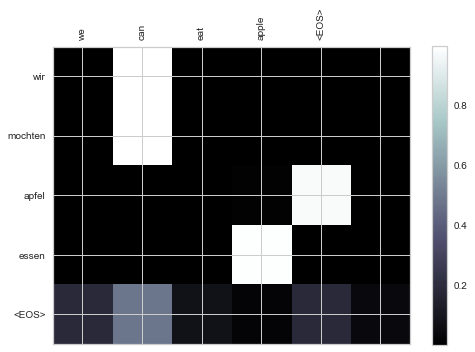

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000002,0.000000,0.074551,0.000061,0.000002,0.000039,0.000004,0.000000,0.000005,0.000000,0.000000,0.000001,0.000000,0.000087,0.925248
2)mochten,0.000119,0.000000,0.000740,0.388791,0.000186,0.040078,0.000941,0.000521,0.262888,0.002265,0.000020,0.005868,0.000105,0.296331,0.001148
3)apfel,0.000437,0.000005,0.000070,0.000140,0.049840,0.000301,0.687043,0.067733,0.000197,0.072240,0.020564,0.000036,0.101203,0.000136,0.000054
4)essen,0.000026,0.020365,0.000014,0.000002,0.000023,0.973972,0.000406,0.000002,0.002951,0.000029,0.000003,0.002130,0.000059,0.000008,0.000010
5)EOS,0.000000,0.999894,0.000000,0.000000,0.000000,0.000005,0.000096,0.000000,0.000001,0.000001,0.000000,0.000001,0.000002,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we can drink water
output = wir konnen wasser trinken <EOS>


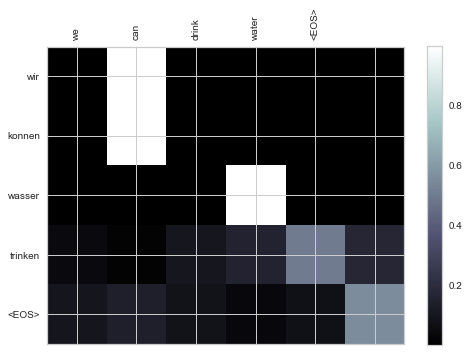

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000318,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000066,0.999614
2)konnen,0.000002,0.000000,0.000006,0.000293,0.000016,0.000038,0.000000,0.000029,0.000054,0.000000,0.000009,0.000031,0.000000,0.999342,0.000179
3)wasser,0.000020,0.000000,0.000001,0.000036,0.000189,0.000000,0.000101,0.996356,0.000357,0.001373,0.001033,0.000001,0.000487,0.000032,0.000014
4)trinken,0.000004,0.000298,0.000001,0.000001,0.000000,0.000007,0.000000,0.000226,0.999402,0.000004,0.000000,0.000034,0.000008,0.000001,0.000013
5)EOS,0.000001,0.999775,0.000000,0.000000,0.000000,0.000000,0.000001,0.000001,0.000023,0.000197,0.000000,0.000001,0.000001,0.000000,0.000000


Apply weight : False
input = we can drink water
output = wir mochten wasser trinken <EOS>


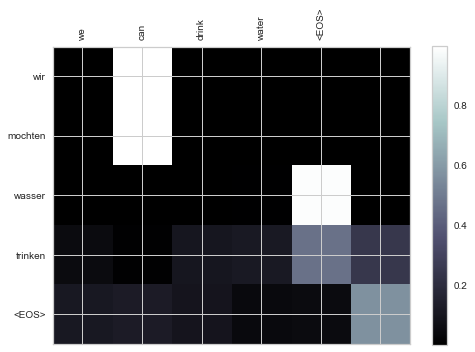

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000002,0.000000,0.022456,0.000052,0.000000,0.000001,0.000000,0.000006,0.000007,0.000000,0.000001,0.000001,0.000000,0.000041,0.977432
2)mochten,0.000103,0.000000,0.000440,0.680897,0.000098,0.000921,0.000010,0.009357,0.225001,0.000223,0.000077,0.003416,0.000024,0.077804,0.001630
3)wasser,0.000313,0.000002,0.000063,0.000090,0.028331,0.000012,0.014301,0.867672,0.000123,0.004266,0.072644,0.000010,0.012098,0.000041,0.000033
4)trinken,0.000177,0.002122,0.000252,0.000061,0.000036,0.001327,0.000035,0.002654,0.991270,0.000056,0.000110,0.001281,0.000232,0.000052,0.000335
5)EOS,0.000001,0.999680,0.000000,0.000000,0.000000,0.000002,0.000004,0.000001,0.000017,0.000287,0.000000,0.000002,0.000004,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we can drink beer
output = wir konnen bier trinken <EOS>


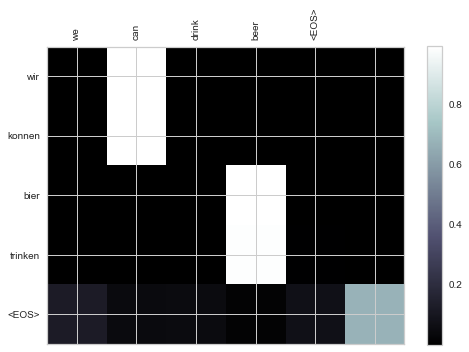

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000322,0.000001,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000069,0.999605
2)konnen,0.000001,0.000000,0.000004,0.000219,0.000007,0.000073,0.000001,0.000002,0.000125,0.000013,0.000001,0.000017,0.000001,0.999461,0.000077
3)bier,0.000002,0.000000,0.000000,0.000003,0.000003,0.000000,0.000328,0.001672,0.000376,0.997551,0.000000,0.000000,0.000063,0.000001,0.000000
4)trinken,0.000000,0.000778,0.000000,0.000000,0.000000,0.000004,0.000000,0.000002,0.999122,0.000089,0.000000,0.000002,0.000001,0.000000,0.000001
5)EOS,0.000000,0.999319,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000016,0.000663,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = we can drink beer
output = wir trinken bier <EOS>


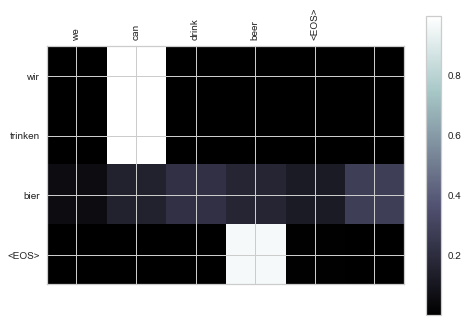

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000003,0.000000,0.091737,0.000103,0.000000,0.000002,0.000000,0.000001,0.000089,0.000011,0.000000,0.000001,0.000000,0.000067,0.907986
2)trinken,0.000039,0.000000,0.000147,0.232324,0.000012,0.000942,0.000015,0.000261,0.714506,0.012813,0.000002,0.002267,0.000034,0.036278,0.000361
3)bier,0.000003,0.000038,0.000000,0.000010,0.000001,0.000001,0.000147,0.000010,0.000011,0.999745,0.000000,0.000001,0.000030,0.000001,0.000001
4)EOS,0.000019,0.927975,0.000008,0.000002,0.000000,0.001368,0.000071,0.000003,0.069680,0.000592,0.000000,0.000225,0.000033,0.000000,0.000023


-------------------------------------------
Apply weight : True
input = we can read book
output = wir konnen buch lesen <EOS>


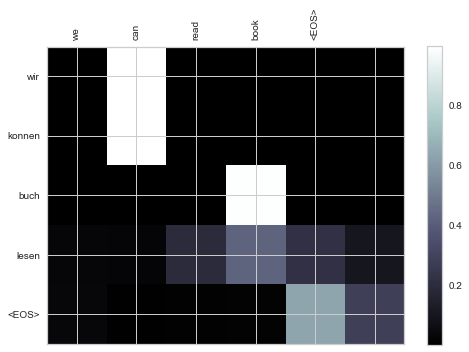

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000288,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000005,0.000001,0.000000,0.000087,0.999618
2)konnen,0.000001,0.000000,0.000004,0.000262,0.000014,0.000017,0.000000,0.000007,0.000007,0.000000,0.000145,0.000114,0.000001,0.999348,0.000080
3)buch,0.000005,0.000000,0.000001,0.000001,0.000734,0.000000,0.000020,0.000751,0.000000,0.000000,0.997176,0.000167,0.001101,0.000036,0.000006
4)lesen,0.000001,0.000097,0.000000,0.000000,0.000000,0.000016,0.000000,0.000000,0.000005,0.000000,0.000266,0.999596,0.000004,0.000000,0.000014
5)EOS,0.000000,0.999899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.000095,0.000000,0.000000


Apply weight : False
input = we can read book
output = wir mochten buch lesen <EOS>


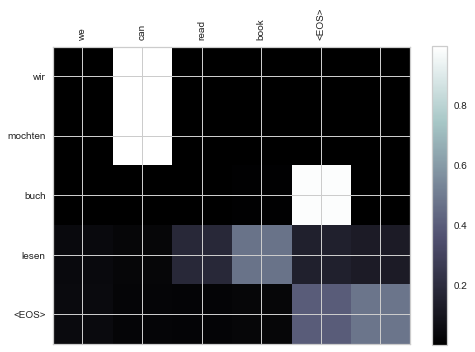

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000003,0.000000,0.063777,0.000067,0.000001,0.000001,0.000000,0.000003,0.000002,0.000000,0.000081,0.000013,0.000000,0.000064,0.935988
2)mochten,0.000161,0.000000,0.000413,0.678999,0.000153,0.000721,0.000013,0.004926,0.059882,0.000108,0.002981,0.042064,0.000177,0.208529,0.000873
3)buch,0.000293,0.000001,0.000036,0.000088,0.020371,0.000009,0.007361,0.218975,0.000029,0.001472,0.717114,0.000061,0.034122,0.000052,0.000016
4)lesen,0.000235,0.034059,0.000128,0.000048,0.000062,0.010621,0.000086,0.000177,0.002861,0.000018,0.002916,0.947791,0.000282,0.000013,0.000702
5)EOS,0.000002,0.999180,0.000000,0.000000,0.000000,0.000071,0.000006,0.000000,0.000015,0.000001,0.000004,0.000173,0.000546,0.000000,0.000001


-------------------------------------------
Apply weight : True
input = we can read newspaper
output = wir konnen zeitung lesen <EOS>


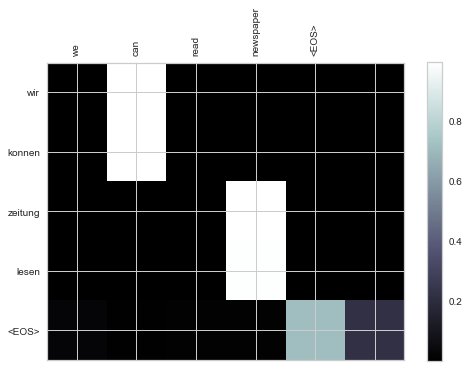

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000341,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000081,0.999575
2)konnen,0.000001,0.000000,0.000005,0.000170,0.000006,0.000039,0.000000,0.000001,0.000017,0.000000,0.000003,0.000208,0.000019,0.999441,0.000090
3)zeitung,0.000004,0.000000,0.000000,0.000002,0.000057,0.000000,0.000073,0.000376,0.000002,0.000096,0.002454,0.000558,0.996364,0.000012,0.000001
4)lesen,0.000000,0.000273,0.000000,0.000000,0.000000,0.000014,0.000000,0.000000,0.000041,0.000000,0.000001,0.999576,0.000092,0.000000,0.000002
5)EOS,0.000000,0.999725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000272,0.000000,0.000000


Apply weight : False
input = we can read newspaper
output = wir mochten zeitung <EOS>


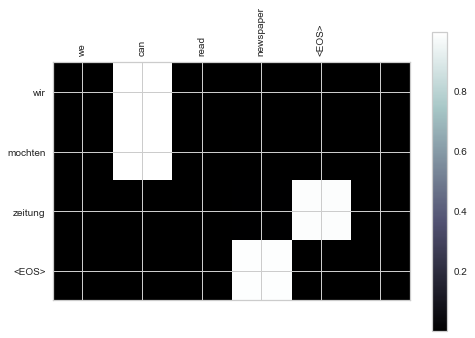

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000002,0.000000,0.064728,0.000053,0.000000,0.000001,0.000000,0.000000,0.000005,0.000000,0.000001,0.000018,0.000002,0.000060,0.935128
2)mochten,0.000117,0.000000,0.000681,0.616283,0.000100,0.002857,0.000033,0.000358,0.082137,0.000522,0.000064,0.063876,0.003843,0.227950,0.001178
3)zeitung,0.000084,0.000004,0.000010,0.000016,0.003066,0.000008,0.009512,0.008842,0.000033,0.004554,0.008962,0.000059,0.964821,0.000021,0.000006
4)EOS,0.000167,0.441813,0.000022,0.000025,0.000050,0.153449,0.000581,0.000016,0.008917,0.000121,0.000054,0.392659,0.000939,0.000029,0.001158


-------------------------------------------
Apply weight : True
input = i eat bread
output = ich essen apfel <EOS>


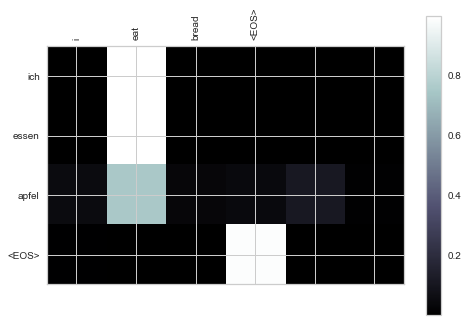

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999226,0.000001,0.000012,0.000289,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000467
2)essen,0.000000,0.000000,0.000022,0.000077,0.000114,0.999556,0.000035,0.000000,0.000011,0.000000,0.000000,0.000025,0.000000,0.000157,0.000002
3)apfel,0.000002,0.002217,0.000000,0.000000,0.000068,0.000136,0.997465,0.000003,0.000001,0.000078,0.000001,0.000000,0.000028,0.000000,0.000000
4)EOS,0.000000,0.999647,0.000000,0.000000,0.000000,0.000341,0.000010,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i eat bread
output = ich essen apfel <EOS>


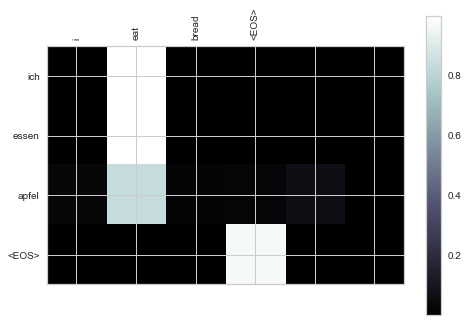

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000003,0.000000,0.952596,0.000074,0.000026,0.000035,0.000000,0.000001,0.000003,0.000000,0.000001,0.000001,0.000000,0.000062,0.047198
2)essen,0.000055,0.000000,0.000914,0.041703,0.005570,0.573212,0.000086,0.000032,0.004111,0.000011,0.000014,0.002673,0.000012,0.366665,0.004942
3)apfel,0.000059,0.000646,0.000004,0.000004,0.001942,0.000265,0.990071,0.000322,0.000042,0.003832,0.000072,0.000013,0.002694,0.000018,0.000015
4)EOS,0.000014,0.778107,0.000005,0.000000,0.000009,0.218794,0.000346,0.000001,0.001576,0.000017,0.000001,0.001092,0.000031,0.000002,0.000005


-------------------------------------------
Apply weight : True
input = i eat apple
output = ich essen apfel <EOS>


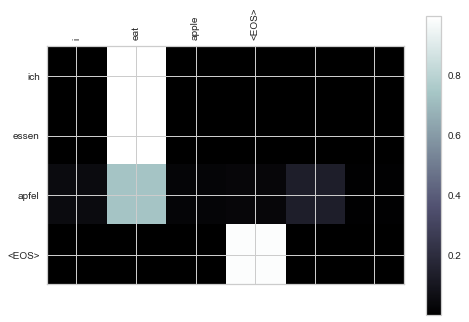

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999533,0.000000,0.000001,0.000110,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000343
2)essen,0.000000,0.000000,0.000031,0.000128,0.000021,0.999104,0.000317,0.000000,0.000026,0.000000,0.000000,0.000027,0.000000,0.000342,0.000003
3)apfel,0.000000,0.000188,0.000000,0.000000,0.000005,0.000032,0.999717,0.000000,0.000000,0.000047,0.000000,0.000000,0.000010,0.000000,0.000000
4)EOS,0.000000,0.999893,0.000000,0.000000,0.000000,0.000090,0.000015,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i eat apple
output = ich essen apfel <EOS>


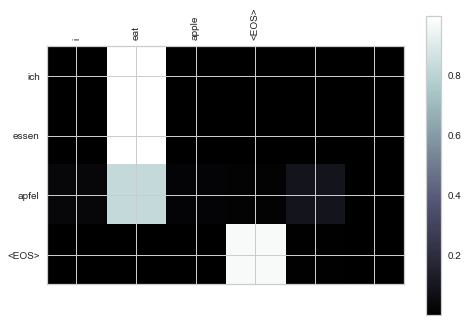

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000001,0.000000,0.960399,0.000040,0.000002,0.000034,0.000001,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,0.000050,0.039468
2)essen,0.000032,0.000000,0.000520,0.048934,0.000584,0.751636,0.000747,0.000013,0.008043,0.000045,0.000005,0.002395,0.000012,0.183736,0.003296
3)apfel,0.000007,0.000094,0.000001,0.000001,0.000073,0.000059,0.997723,0.000025,0.000008,0.001437,0.000010,0.000002,0.000555,0.000002,0.000002
4)EOS,0.000004,0.950509,0.000001,0.000000,0.000001,0.048279,0.000569,0.000000,0.000402,0.000011,0.000000,0.000200,0.000021,0.000000,0.000001


-------------------------------------------
Apply weight : True
input = i drink water
output = ich trinken bier <EOS>


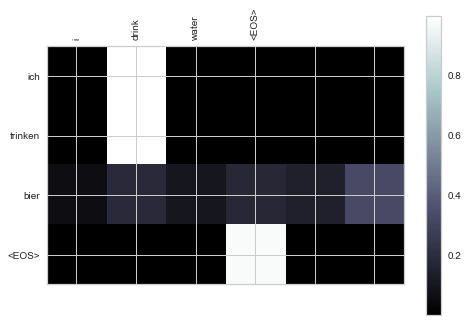

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999612,0.000001,0.000000,0.000000,0.000000,0.000004,0.000078,0.000000,0.000000,0.000000,0.000000,0.000002,0.000303
2)trinken,0.000002,0.000000,0.000036,0.000983,0.000000,0.000031,0.000000,0.000526,0.997960,0.000098,0.000000,0.000092,0.000002,0.000266,0.000001
3)bier,0.000014,0.001706,0.000002,0.000007,0.000003,0.000002,0.000260,0.000636,0.000173,0.997095,0.000002,0.000002,0.000098,0.000001,0.000000
4)EOS,0.000000,0.999661,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000338,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i drink water
output = ich konnen brot essen <EOS>


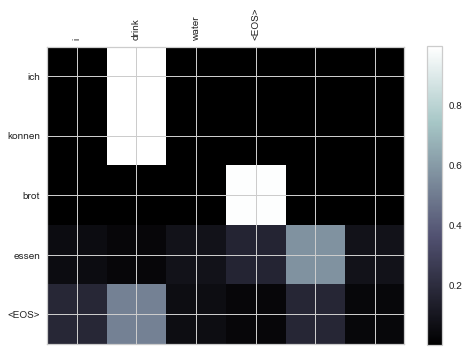

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000001,0.000000,0.983726,0.000029,0.000000,0.000000,0.000000,0.000007,0.000007,0.000000,0.000001,0.000000,0.000000,0.000012,0.016216
2)konnen,0.000153,0.000000,0.003270,0.299455,0.000866,0.066698,0.000031,0.001048,0.052513,0.000029,0.000123,0.009313,0.000017,0.556820,0.009664
3)brot,0.000525,0.000001,0.000353,0.001680,0.403042,0.000799,0.144091,0.393220,0.000161,0.016134,0.034133,0.000022,0.005578,0.000237,0.000025
4)essen,0.000061,0.002806,0.000044,0.000049,0.000231,0.992125,0.000169,0.000042,0.002167,0.000032,0.000039,0.002119,0.000060,0.000015,0.000040
5)EOS,0.000001,0.999657,0.000000,0.000000,0.000000,0.000014,0.000306,0.000001,0.000004,0.000006,0.000001,0.000002,0.000009,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i drink beer
output = ich trinken bier <EOS>


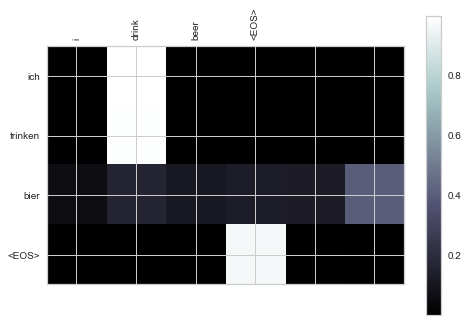

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000001,0.000000,0.999085,0.000001,0.000000,0.000000,0.000000,0.000001,0.000453,0.000010,0.000000,0.000000,0.000000,0.000004,0.000446
2)trinken,0.000001,0.000000,0.000011,0.000161,0.000000,0.000027,0.000000,0.000008,0.998063,0.001586,0.000000,0.000030,0.000001,0.000111,0.000001
3)bier,0.000001,0.000135,0.000000,0.000000,0.000000,0.000000,0.000019,0.000003,0.000012,0.999823,0.000000,0.000000,0.000008,0.000000,0.000000
4)EOS,0.000000,0.999714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000276,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = i drink beer
output = ich konnen bier trinken <EOS>


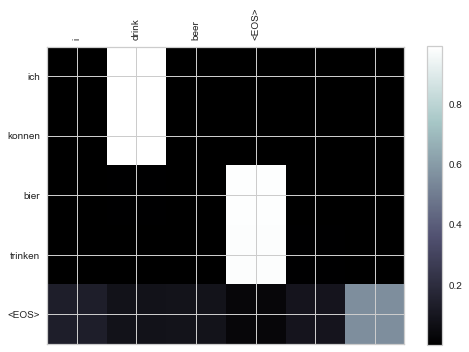

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000002,0.000000,0.957910,0.000043,0.000000,0.000004,0.000000,0.000000,0.000041,0.000006,0.000000,0.000000,0.000000,0.000027,0.041965
2)konnen,0.000127,0.000000,0.002324,0.166797,0.000325,0.143700,0.000124,0.000072,0.190354,0.003143,0.000008,0.007946,0.000061,0.476810,0.008209
3)bier,0.000236,0.000002,0.000139,0.000633,0.075769,0.001069,0.283807,0.010565,0.000270,0.618624,0.001222,0.000009,0.007557,0.000086,0.000012
4)trinken,0.000089,0.045991,0.000261,0.000022,0.000014,0.060278,0.000329,0.000029,0.889854,0.000251,0.000005,0.002645,0.000117,0.000005,0.000112
5)EOS,0.000000,0.999851,0.000000,0.000000,0.000000,0.000003,0.000002,0.000000,0.000003,0.000139,0.000000,0.000000,0.000001,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = i read book
output = ich lesen zeitung <EOS>


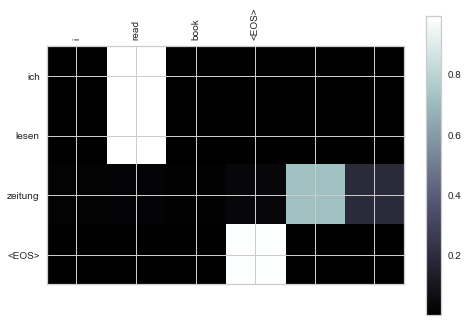

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999477,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000092,0.000060,0.000000,0.000008,0.000361
2)lesen,0.000001,0.000000,0.000006,0.000349,0.000000,0.000070,0.000000,0.000002,0.000078,0.000000,0.000177,0.999031,0.000048,0.000236,0.000001
3)zeitung,0.000011,0.001133,0.000001,0.000001,0.000005,0.000008,0.000102,0.000062,0.000052,0.000042,0.000447,0.000279,0.997853,0.000003,0.000000
4)EOS,0.000000,0.999846,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000002,0.000000,0.000000,0.000148,0.000002,0.000000,0.000000


Apply weight : False
input = i read book
output = ich konnen buch lesen <EOS>


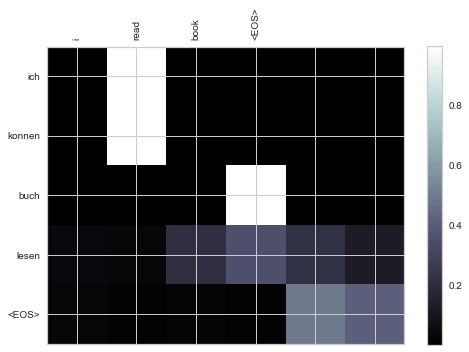

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000002,0.000000,0.968489,0.000037,0.000000,0.000001,0.000000,0.000002,0.000002,0.000000,0.000035,0.000006,0.000000,0.000031,0.031395
2)konnen,0.000111,0.000000,0.001508,0.180544,0.000463,0.036519,0.000027,0.000199,0.010271,0.000007,0.001307,0.058979,0.000051,0.699852,0.010162
3)buch,0.000726,0.000001,0.000190,0.002047,0.297008,0.000814,0.156676,0.168184,0.000101,0.012269,0.338451,0.000197,0.022910,0.000392,0.000035
4)lesen,0.000161,0.019652,0.000084,0.000065,0.000098,0.031803,0.000213,0.000090,0.002285,0.000033,0.001387,0.943508,0.000155,0.000011,0.000455
5)EOS,0.000002,0.999311,0.000000,0.000000,0.000000,0.000068,0.000007,0.000000,0.000014,0.000001,0.000002,0.000131,0.000463,0.000000,0.000001


-------------------------------------------
Apply weight : True
input = i read newspaper
output = ich lesen zeitung <EOS>


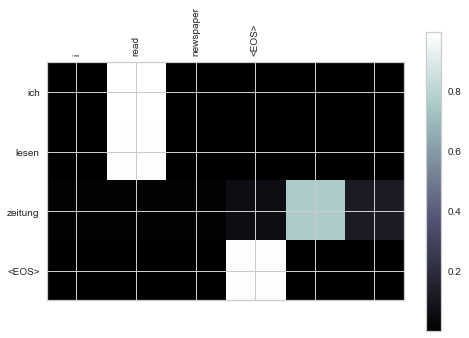

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000000,0.000000,0.999471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000135,0.000003,0.000005,0.000383
2)lesen,0.000000,0.000000,0.000006,0.000131,0.000000,0.000134,0.000000,0.000000,0.000096,0.000000,0.000005,0.998661,0.000812,0.000153,0.000001
3)zeitung,0.000001,0.000443,0.000000,0.000000,0.000000,0.000002,0.000023,0.000001,0.000012,0.000016,0.000003,0.000045,0.999453,0.000000,0.000000
4)EOS,0.000000,0.999956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000037,0.000005,0.000000,0.000000


Apply weight : False
input = i read newspaper
output = ich konnen apfel essen <EOS>


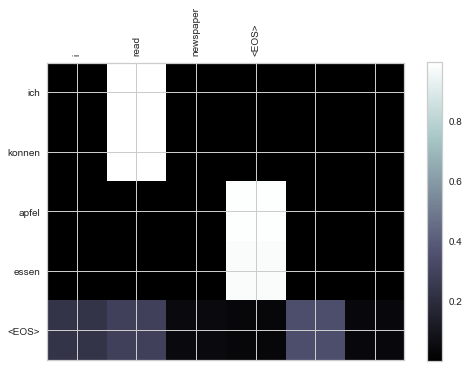

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)ich,0.000004,0.000000,0.836477,0.000110,0.000001,0.000004,0.000000,0.000001,0.000010,0.000000,0.000002,0.000025,0.000003,0.000067,0.163296
2)konnen,0.000122,0.000000,0.000912,0.251189,0.000524,0.064273,0.000103,0.000065,0.022221,0.000123,0.000069,0.143146,0.003523,0.506682,0.007049
3)apfel,0.000325,0.000011,0.000090,0.000417,0.063206,0.000881,0.543373,0.008787,0.000075,0.047079,0.007154,0.000168,0.328332,0.000083,0.000018
4)essen,0.000023,0.051671,0.000012,0.000003,0.000027,0.937388,0.000246,0.000001,0.001749,0.000015,0.000003,0.008583,0.000266,0.000004,0.000008
5)EOS,0.000000,0.999902,0.000000,0.000000,0.000000,0.000003,0.000087,0.000000,0.000001,0.000001,0.000000,0.000001,0.000006,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we eat bread
output = wir essen apfel <EOS>


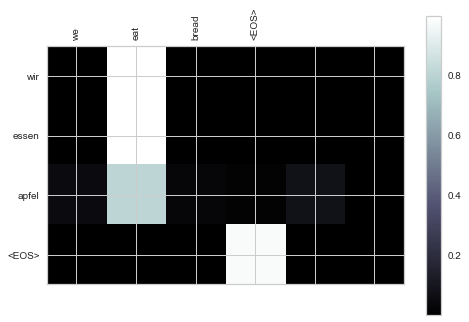

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000253,0.000001,0.000008,0.000312,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.999423
2)essen,0.000001,0.000000,0.000002,0.000350,0.000403,0.998495,0.000059,0.000000,0.000019,0.000000,0.000000,0.000052,0.000000,0.000451,0.000168
3)apfel,0.000004,0.000984,0.000000,0.000000,0.000216,0.000319,0.998345,0.000007,0.000002,0.000083,0.000002,0.000001,0.000035,0.000000,0.000003
4)EOS,0.000000,0.998810,0.000000,0.000000,0.000000,0.001176,0.000011,0.000000,0.000002,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000


Apply weight : False
input = we eat bread
output = wir mochten brot essen <EOS>


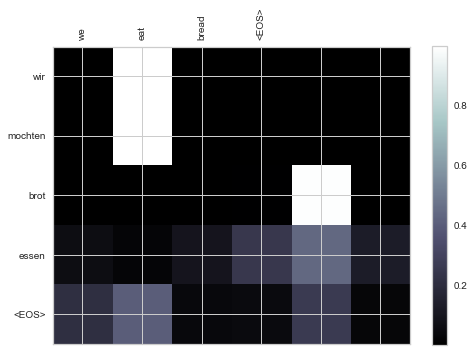

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000004,0.000000,0.067825,0.000138,0.000038,0.000031,0.000000,0.000002,0.000004,0.000000,0.000001,0.000001,0.000000,0.000081,0.931875
2)mochten,0.000176,0.000000,0.000703,0.761447,0.003553,0.020629,0.000040,0.001684,0.059409,0.000305,0.000063,0.006905,0.000091,0.143886,0.001111
3)brot,0.000820,0.000016,0.000104,0.000158,0.487191,0.000324,0.074983,0.289103,0.000200,0.018056,0.039999,0.000030,0.088855,0.000113,0.000048
4)essen,0.000119,0.025666,0.000035,0.000026,0.000402,0.963254,0.000151,0.000045,0.005449,0.000054,0.000041,0.004311,0.000272,0.000020,0.000154
5)EOS,0.000000,0.999872,0.000000,0.000000,0.000000,0.000005,0.000114,0.000000,0.000001,0.000001,0.000000,0.000001,0.000005,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we eat apple
output = wir essen apfel <EOS>


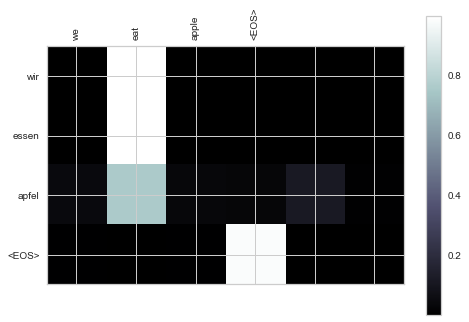

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000255,0.000001,0.000001,0.000512,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.999215
2)essen,0.000001,0.000000,0.000001,0.000265,0.000037,0.998312,0.000624,0.000000,0.000031,0.000001,0.000000,0.000081,0.000000,0.000478,0.000169
3)apfel,0.000000,0.000290,0.000000,0.000000,0.000004,0.000054,0.999598,0.000000,0.000000,0.000041,0.000000,0.000000,0.000010,0.000000,0.000001
4)EOS,0.000000,0.999882,0.000000,0.000000,0.000000,0.000106,0.000011,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = we eat apple
output = wir mochten apfel essen <EOS>


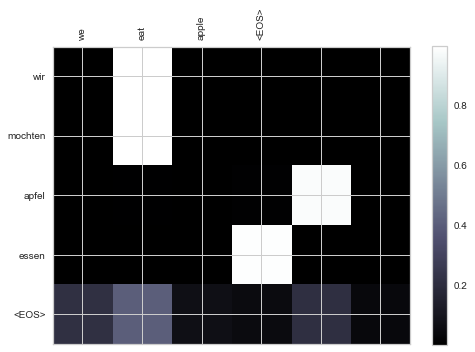

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000001,0.000000,0.007764,0.000018,0.000001,0.000028,0.000002,0.000000,0.000001,0.000000,0.000000,0.000001,0.000000,0.000020,0.992165
2)mochten,0.000131,0.000000,0.000619,0.581604,0.000398,0.045081,0.001139,0.000621,0.124937,0.001878,0.000031,0.005523,0.000105,0.236142,0.001790
3)apfel,0.000298,0.000004,0.000069,0.000061,0.067948,0.000414,0.821487,0.020956,0.000033,0.019642,0.019437,0.000015,0.049517,0.000087,0.000032
4)essen,0.000020,0.028667,0.000008,0.000002,0.000011,0.963026,0.000188,0.000002,0.003621,0.000017,0.000002,0.004371,0.000044,0.000005,0.000015
5)EOS,0.000000,0.999890,0.000000,0.000000,0.000000,0.000004,0.000101,0.000000,0.000001,0.000001,0.000000,0.000001,0.000002,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we drink water
output = wir trinken bier <EOS>


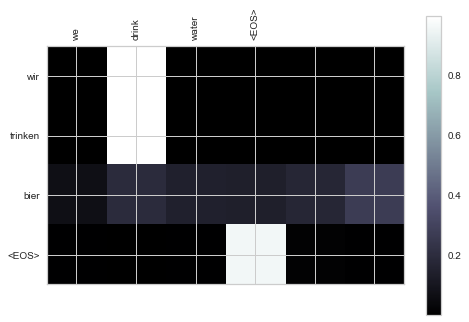

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000159,0.000001,0.000000,0.000000,0.000000,0.000003,0.000093,0.000000,0.000000,0.000000,0.000000,0.000001,0.999743
2)trinken,0.000002,0.000000,0.000001,0.000912,0.000000,0.000022,0.000000,0.000378,0.998189,0.000049,0.000000,0.000118,0.000001,0.000212,0.000116
3)bier,0.000017,0.001036,0.000000,0.000013,0.000003,0.000001,0.000231,0.001049,0.000242,0.997321,0.000002,0.000003,0.000075,0.000002,0.000006
4)EOS,0.000000,0.998966,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.001031,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = we drink water
output = wir mochten wasser trinken <EOS>


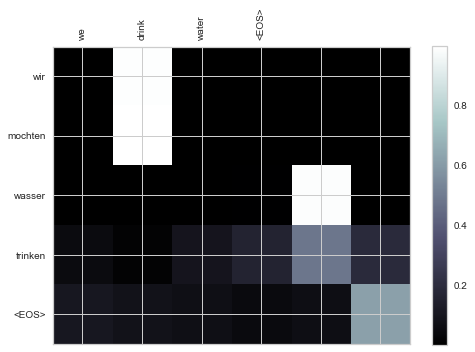

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000002,0.000000,0.026389,0.000042,0.000000,0.000001,0.000000,0.000009,0.000017,0.000000,0.000001,0.000000,0.000000,0.000015,0.973524
2)mochten,0.000096,0.000000,0.000408,0.801967,0.000100,0.000790,0.000010,0.007848,0.140907,0.000209,0.000080,0.004148,0.000024,0.042278,0.001134
3)wasser,0.000298,0.000002,0.000026,0.000139,0.014553,0.000008,0.010472,0.908894,0.000226,0.007830,0.036290,0.000014,0.021186,0.000032,0.000030
4)trinken,0.000125,0.004209,0.000116,0.000039,0.000012,0.000765,0.000023,0.001458,0.991219,0.000054,0.000044,0.001300,0.000291,0.000029,0.000316
5)EOS,0.000001,0.999833,0.000000,0.000000,0.000000,0.000001,0.000002,0.000000,0.000008,0.000152,0.000000,0.000001,0.000003,0.000000,0.000000


-------------------------------------------
Apply weight : True
input = we drink beer
output = wir trinken bier <EOS>


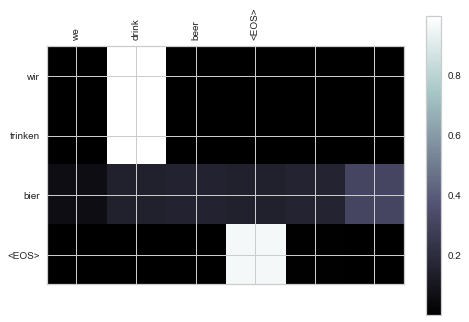

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000219,0.000001,0.000000,0.000000,0.000000,0.000000,0.000247,0.000004,0.000000,0.000000,0.000000,0.000002,0.999527
2)trinken,0.000001,0.000000,0.000000,0.000185,0.000000,0.000016,0.000000,0.000008,0.998527,0.001112,0.000000,0.000036,0.000001,0.000095,0.000019
3)bier,0.000001,0.000104,0.000000,0.000000,0.000000,0.000000,0.000027,0.000003,0.000014,0.999846,0.000000,0.000000,0.000006,0.000000,0.000000
4)EOS,0.000000,0.999710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000283,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000


Apply weight : False
input = we drink beer
output = wir trinken bier <EOS>


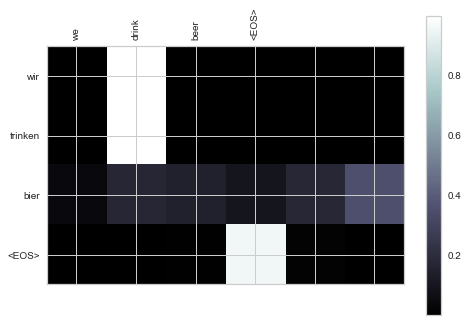

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000002,0.000000,0.010912,0.000092,0.000000,0.000002,0.000000,0.000000,0.000051,0.000004,0.000000,0.000001,0.000000,0.000032,0.988903
2)trinken,0.000048,0.000000,0.000162,0.346973,0.000026,0.001291,0.000026,0.000352,0.581515,0.014880,0.000003,0.001827,0.000050,0.052478,0.000369
3)bier,0.000002,0.000037,0.000000,0.000006,0.000001,0.000001,0.000112,0.000008,0.000005,0.999795,0.000000,0.000000,0.000032,0.000001,0.000000
4)EOS,0.000016,0.969793,0.000004,0.000001,0.000000,0.000972,0.000073,0.000003,0.028287,0.000696,0.000000,0.000100,0.000034,0.000000,0.000020


-------------------------------------------
Apply weight : True
input = we read book
output = wir lesen zeitung <EOS>


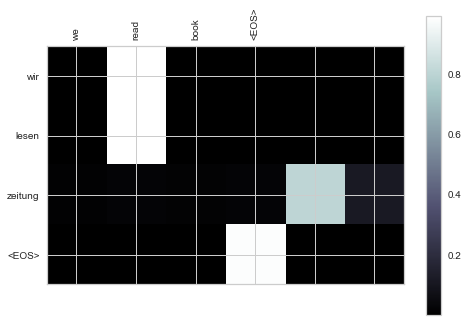

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000121,0.000001,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000021,0.000244,0.000000,0.000002,0.999608
2)lesen,0.000001,0.000000,0.000000,0.000538,0.000001,0.000051,0.000000,0.000003,0.000040,0.000000,0.000426,0.998583,0.000055,0.000256,0.000046
3)zeitung,0.000009,0.000606,0.000000,0.000001,0.000005,0.000007,0.000074,0.000061,0.000037,0.000022,0.000527,0.000256,0.998389,0.000003,0.000002
4)EOS,0.000000,0.999295,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000008,0.000000,0.000000,0.000686,0.000004,0.000000,0.000000


Apply weight : False
input = we read book
output = wir mochten buch lesen <EOS>


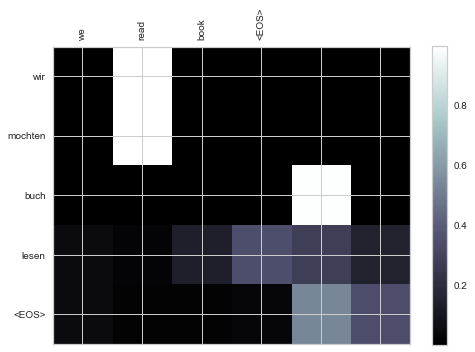

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000003,0.000000,0.026337,0.000071,0.000001,0.000001,0.000000,0.000003,0.000001,0.000000,0.000084,0.000010,0.000000,0.000042,0.973446
2)mochten,0.000128,0.000000,0.000449,0.724457,0.000080,0.000973,0.000007,0.002131,0.062745,0.000059,0.001851,0.072189,0.000153,0.133177,0.001599
3)buch,0.000394,0.000002,0.000046,0.000076,0.013842,0.000005,0.009631,0.263191,0.000046,0.002548,0.634370,0.000049,0.075714,0.000063,0.000024
4)lesen,0.000657,0.113379,0.000268,0.000069,0.000201,0.012599,0.000327,0.000549,0.003028,0.000069,0.009458,0.856538,0.001095,0.000027,0.001736
5)EOS,0.000002,0.999256,0.000000,0.000000,0.000000,0.000047,0.000004,0.000000,0.000016,0.000001,0.000003,0.000103,0.000566,0.000000,0.000001


-------------------------------------------
Apply weight : True
input = we read newspaper
output = wir lesen zeitung <EOS>


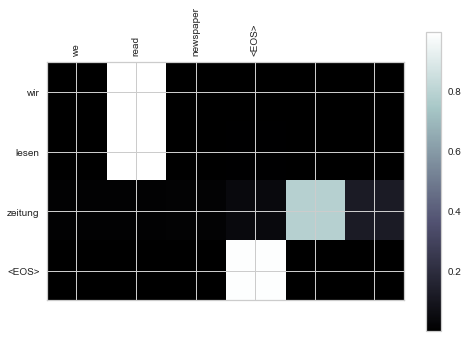

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000000,0.000000,0.000291,0.000001,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000001,0.000402,0.000003,0.000002,0.999298
2)lesen,0.000000,0.000000,0.000000,0.000199,0.000000,0.000062,0.000000,0.000000,0.000095,0.000000,0.000006,0.998576,0.000906,0.000118,0.000037
3)zeitung,0.000001,0.000373,0.000000,0.000000,0.000000,0.000002,0.000028,0.000002,0.000013,0.000015,0.000005,0.000067,0.999493,0.000001,0.000000
4)EOS,0.000000,0.999912,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000002,0.000000,0.000000,0.000080,0.000005,0.000000,0.000000


Apply weight : False
input = we read newspaper
output = wir mochten zeitung <EOS>


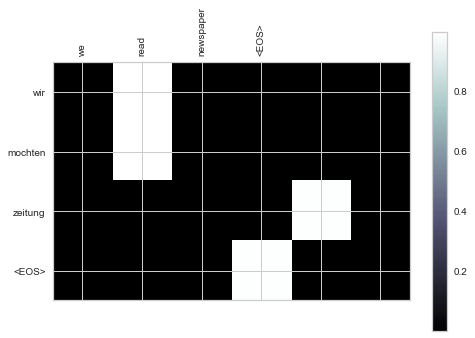

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
1)wir,0.000002,0.000000,0.038863,0.000055,0.000000,0.000001,0.000000,0.000000,0.000005,0.000000,0.000001,0.000022,0.000002,0.000038,0.961008
2)mochten,0.000143,0.000000,0.000704,0.455483,0.000066,0.001892,0.000039,0.000714,0.258715,0.001274,0.000068,0.085699,0.007209,0.187224,0.000769
3)zeitung,0.000094,0.000008,0.000012,0.000010,0.003334,0.000011,0.023157,0.009368,0.000043,0.006758,0.008871,0.000054,0.948253,0.000023,0.000004
4)EOS,0.000095,0.461859,0.000013,0.000016,0.000023,0.121086,0.000381,0.000007,0.006005,0.000081,0.000026,0.409448,0.000483,0.000015,0.000461


In [66]:
all_valid_inputs = [p[0] for p in pairs]
all_encoder_states = []
for valid_input in all_valid_inputs:
    print("-------------------------------------------")
    evaluate_queue = []
    
    attentions,output_words = evaluateAndShowAttention(valid_input,is_appy_weight=True,dump_display=True)
    key_items = get_eval_value(evaluate_queue,"decoder_output")
    display(draw_attention_map(key_items,output_words))    
    
    key_items_encoder_stated = get_eval_value(evaluate_queue,"encoder_hidden_decoder_hidden")    
    all_encoder_states.append( key_items_encoder_stated[0].data.numpy().flatten() )
    
    evaluate_queue = []
    attentions,output_words = evaluateAndShowAttention(valid_input,is_appy_weight=False,dump_display=True)
    key_items = get_eval_value(evaluate_queue,"decoder_output")
    display(draw_attention_map(key_items,output_words))
    
    
Xs,Ys = [],[]    
for index,valid_input in enumerate(all_valid_inputs):    
    Ys.append(valid_input)
    Xs.append(all_encoder_states[index])

(36, 256)
(36,)


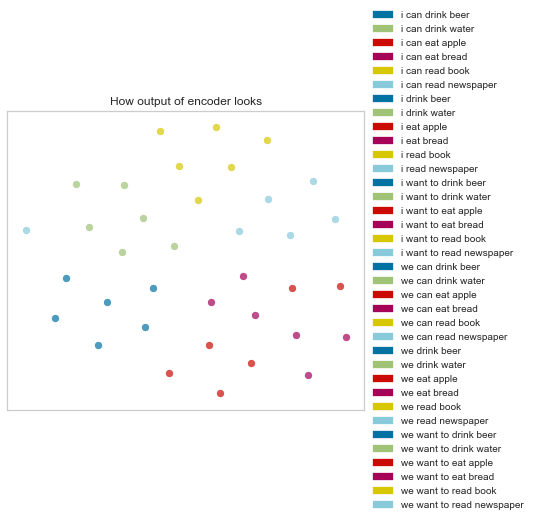

In [67]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
    
#all_encoder_states[0].shape
from yellowbrick.text import TSNEVisualizer
print(np.array(Xs).shape )
print(np.array(Ys).shape )

tsne = TSNEVisualizer(labels=all_valid_inputs,title="How output of encoder looks")

fitted = tsne.fit(np.array(Xs), Ys)
tsne.show()

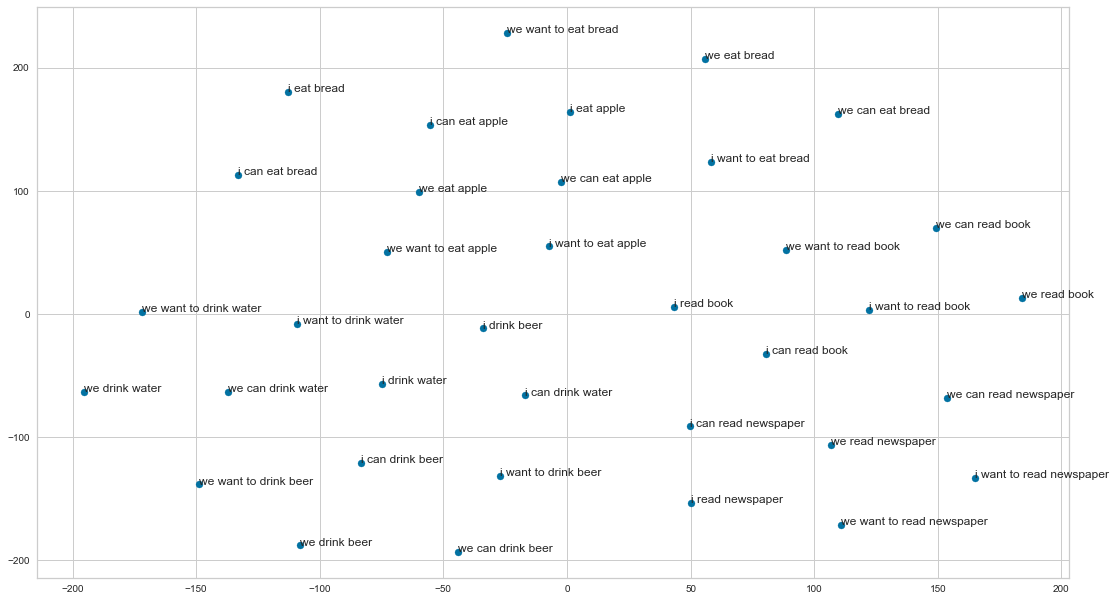

In [82]:
result = fitted.transformer_.fit_transform(np.array(Xs))

import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

#scatter result words
plt.scatter(result[:, 0], result[:, 1])
words = list(Ys)
#put an annotation on x,y cordinates for words
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


input = i can drink beer
output = ich konnen bier trinken <EOS>


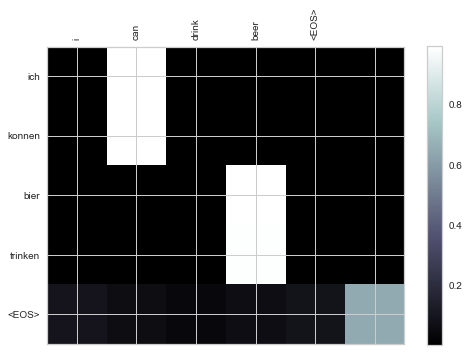

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
0,0.000000,0.000000,0.999686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000073,0.000239
1,0.000001,0.000000,0.000120,0.000145,0.000006,0.000059,0.000000,0.000001,0.000089,0.000008,0.000000,0.000009,0.000000,0.999560,0.000003
2,0.000002,0.000000,0.000000,0.000002,0.000003,0.000000,0.000242,0.001677,0.000385,0.997611,0.000000,0.000000,0.000077,0.000001,0.000000
3,0.000000,0.000986,0.000001,0.000000,0.000000,0.000005,0.000000,0.000001,0.998907,0.000096,0.000000,0.000002,0.000001,0.000000,0.000000
4,0.000000,0.999303,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000015,0.000681,0.000000,0.000000,0.000000,0.000000,0.000000


input = i can drink beer
output = ich konnen bier trinken <EOS>


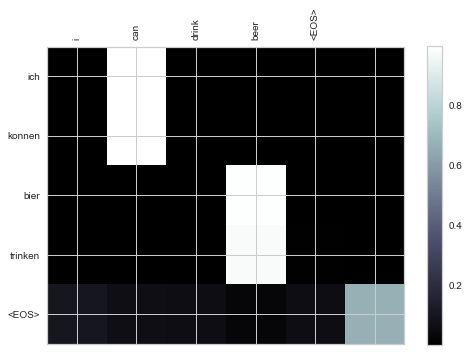

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
0,0.000002,0.000000,0.910296,0.000050,0.000000,0.000002,0.000000,0.000001,0.000050,0.000005,0.000000,0.000000,0.000000,0.000076,0.089517
1,0.000077,0.000000,0.001182,0.152080,0.000290,0.081791,0.000103,0.000048,0.083013,0.001735,0.000007,0.003985,0.000032,0.671121,0.004536
2,0.000247,0.000001,0.000112,0.000631,0.066952,0.000757,0.234841,0.014277,0.000279,0.672510,0.001359,0.000008,0.007886,0.000125,0.000015
3,0.000093,0.106978,0.000145,0.000015,0.000012,0.053775,0.000445,0.000035,0.835941,0.000370,0.000004,0.001906,0.000176,0.000004,0.000101
4,0.000000,0.999905,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000002,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
evaluate_queue = []
evaluateAndShowAttention("i can drink beer")
key_items = get_eval_value(evaluate_queue,"decoder_output")
display(draw_attention_map(key_items))

evaluate_queue = []
evaluateAndShowAttention("i can drink beer",False)
#at 2nd sample 
#1st step since no attention, after "wir" "guess is "trinken"

key_items = get_eval_value(evaluate_queue,"decoder_output")
display(draw_attention_map(key_items))

input = we can drink beer
output = wir konnen bier trinken <EOS>


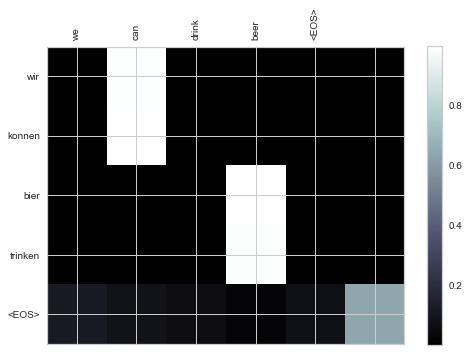

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
0,0.000000,0.000000,0.000203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000050,0.999744
1,0.000001,0.000000,0.000004,0.000176,0.000005,0.000068,0.000001,0.000001,0.000156,0.000011,0.000001,0.000017,0.000000,0.999456,0.000103
2,0.000002,0.000000,0.000000,0.000003,0.000003,0.000000,0.000275,0.001818,0.000396,0.997430,0.000000,0.000000,0.000070,0.000002,0.000000
3,0.000000,0.000375,0.000000,0.000000,0.000000,0.000004,0.000000,0.000001,0.999546,0.000069,0.000000,0.000002,0.000001,0.000000,0.000001
4,0.000000,0.998777,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000022,0.001198,0.000000,0.000000,0.000000,0.000000,0.000000


input = we can drink beer
output = wir trinken bier <EOS>


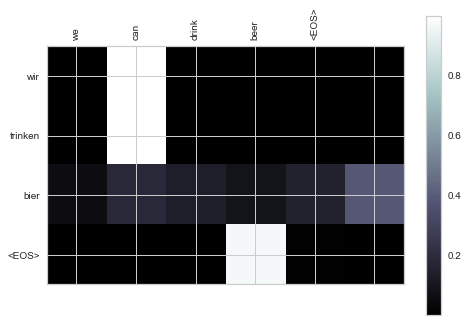

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
0,0.000002,0.000000,0.048274,0.000038,0.000000,0.000002,0.000000,0.000000,0.000036,0.000004,0.000000,0.000000,0.000000,0.000037,0.951606
1,0.000082,0.000000,0.000265,0.199938,0.000031,0.001233,0.000046,0.000614,0.689628,0.036561,0.000006,0.002102,0.000080,0.068840,0.000573
2,0.000003,0.000042,0.000000,0.000006,0.000001,0.000001,0.000093,0.000010,0.000009,0.999802,0.000000,0.000001,0.000032,0.000001,0.000001
3,0.000027,0.956994,0.000017,0.000003,0.000001,0.001668,0.000104,0.000004,0.039979,0.000840,0.000001,0.000292,0.000046,0.000001,0.000025


In [34]:
evaluate_queue = []
evaluateAndShowAttention("we can drink beer")
key_items = get_eval_value(evaluate_queue,"decoder_output")
display(draw_attention_map(key_items))

evaluate_queue = []
evaluateAndShowAttention("we can drink beer",False)
#at 2nd sample 
#1st step since no attention, after "wir" "guess is "trinken"

key_items = get_eval_value(evaluate_queue,"decoder_output")
display(draw_attention_map(key_items))

In [35]:
#evaluate_queue
F.log_softmax(torch.tensor([-11.1]) )

C:\Users\mcelikkaya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


tensor([0.])

In [36]:


key_values = [ np.exp( valcel ) for krow in key_items for valcel in krow.data.numpy().flatten()]
key_values = [ np.exp( krow.data.numpy().flatten() ) for krow in key_items ]

df2 = pd.DataFrame(key_values,columns=[i for i in output_lang.index2word.values()])

#df3 =df2.style.apply(highlight_max)
#df3


cm = sns.light_palette("blue", as_cmap=True)

s = df2.style.background_gradient(cmap=cm)
s

,SOS,EOS,ich,mochten,brot,essen,apfel,wasser,trinken,bier,buch,lesen,zeitung,konnen,wir
0,0.000002,0.000000,0.048274,0.000038,0.000000,0.000002,0.000000,0.000000,0.000036,0.000004,0.000000,0.000000,0.000000,0.000037,0.951606
1,0.000082,0.000000,0.000265,0.199938,0.000031,0.001233,0.000046,0.000614,0.689628,0.036561,0.000006,0.002102,0.000080,0.068840,0.000573
2,0.000003,0.000042,0.000000,0.000006,0.000001,0.000001,0.000093,0.000010,0.000009,0.999802,0.000000,0.000001,0.000032,0.000001,0.000001
3,0.000027,0.956994,0.000017,0.000003,0.000001,0.001668,0.000104,0.000004,0.039979,0.000840,0.000001,0.000292,0.000046,0.000001,0.000025


In [37]:
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})
df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],
               axis=1)
df.iloc[3, 3] = np.nan
df.iloc[0, 2] = np.nan

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color




input = i want to eat apple
output = ich mochten apfel essen <EOS>


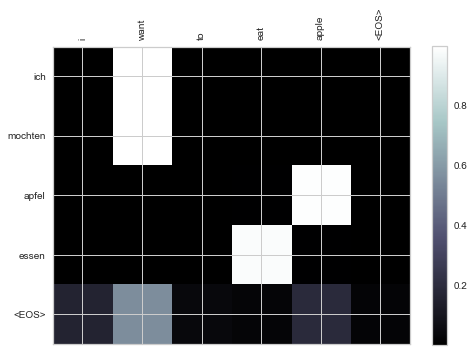

tensor([[4.2276e-04, 9.9687e-01, 8.0073e-04, 1.2901e-03, 4.7836e-04, 1.4212e-04],
        [1.9115e-04, 9.9765e-01, 9.1744e-04, 6.8035e-04, 4.6661e-04, 9.7687e-05],
        [5.6401e-04, 1.5693e-03, 9.5551e-04, 5.3544e-03, 9.9107e-01, 4.9061e-04],
        [3.3745e-03, 2.6025e-03, 3.3284e-03, 9.8291e-01, 5.9230e-03, 1.8581e-03],
        [1.6107e-01, 5.5744e-01, 4.1861e-02, 2.3861e-02, 1.9313e-01, 2.2636e-02]])

In [38]:
evaluateAndShowAttention("i want to eat apple")

input = i want to read book
output = ich mochten buch lesen <EOS>


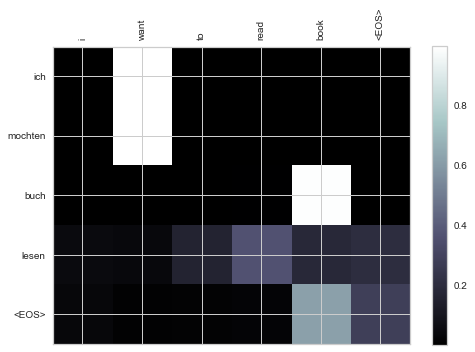

tensor([[4.4157e-04, 9.9582e-01, 8.5815e-04, 2.1916e-03, 5.0148e-04, 1.8484e-04],
        [2.0451e-04, 9.9672e-01, 8.2961e-04, 1.4279e-03, 6.2077e-04, 1.9309e-04],
        [7.0864e-04, 2.2347e-03, 9.7789e-04, 5.2956e-03, 9.9009e-01, 6.9305e-04],
        [4.8587e-02, 4.1717e-02, 1.6336e-01, 3.6261e-01, 1.8033e-01, 2.0340e-01],
        [3.8273e-02, 1.5294e-02, 1.6593e-02, 2.1437e-02, 6.2170e-01, 2.8670e-01]])

In [39]:
evaluateAndShowAttention("i want to read book")


input = i want to read apple
output = ich mochten apfel lesen <EOS>


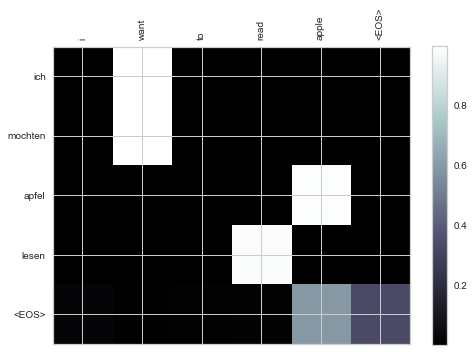

tensor([[3.6615e-04, 9.9771e-01, 6.6437e-04, 8.1617e-04, 3.5331e-04, 9.2986e-05],
        [2.2789e-04, 9.9716e-01, 9.4939e-04, 8.8669e-04, 6.2612e-04, 1.4628e-04],
        [5.8104e-04, 3.1210e-03, 9.1031e-04, 7.2777e-03, 9.8742e-01, 6.9268e-04],
        [2.4710e-03, 1.2350e-03, 2.6262e-03, 9.8463e-01, 6.7382e-03, 2.2996e-03],
        [2.6893e-02, 8.2660e-03, 1.5597e-02, 1.8221e-02, 5.9587e-01, 3.3516e-01]])

In [40]:
evaluateAndShowAttention("i want to read apple")

In [41]:
import math

def myround(n):
    if n == 0:
        return 0
    sgn = -1 if n < 0 else 1
    scale = int(-math.floor(math.log10(abs(n))))
    if scale <= 0:
        scale = 1
    factor = 10**scale
    return sgn*math.floor(abs(n)*factor)/factor

def format_float(num):
    return np.format_float_positional(num, trim='-')

def format_floats(attentions):
    
    pretty_printed = []
    for attention_list in attentions:
        pretty_printed.append( [ myround(num) for num in attention_list] )
    
    return pretty_printed



input = i want to book read
output = ich mochten buch lesen <EOS>


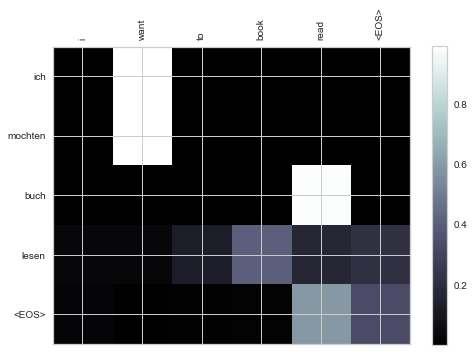

attentions torch.Size([5, 6])
tensor([[5.3983e-04, 9.9630e-01, 9.7357e-04, 1.5595e-03, 4.4004e-04, 1.8985e-04],
        [3.9027e-04, 9.9604e-01, 1.0775e-03, 1.3895e-03, 9.2056e-04, 1.7799e-04],
        [6.3377e-04, 3.4506e-03, 1.4769e-03, 7.4340e-03, 9.8606e-01, 9.4606e-04],
        [3.2603e-02, 3.1443e-02, 1.3523e-01, 4.0957e-01, 1.7464e-01, 2.1650e-01],
        [2.6806e-02, 1.1067e-02, 1.5449e-02, 1.7542e-02, 5.9397e-01, 3.3517e-01]])
input = i book book
output = ich konnen buch <EOS>


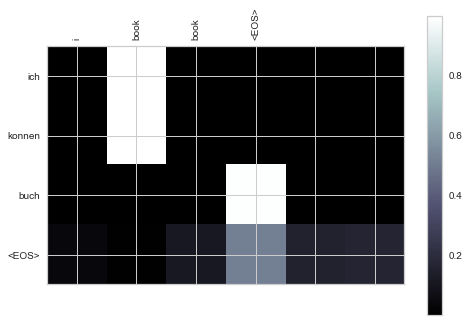

In [42]:
attentions = evaluateAndShowAttention("i want to book read")
print("attentions",attentions.shape)
print(attentions)

format_floats(attentions.data.numpy())
attentions = evaluateAndShowAttention("i book book")

input = i apple apple
output = ich essen apfel <EOS>


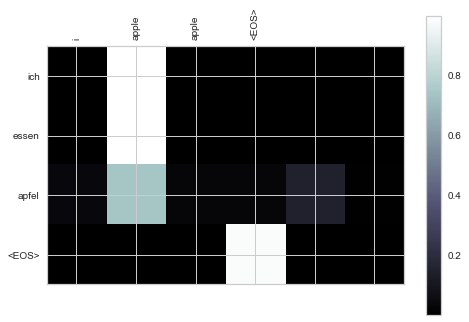

[[0.0006, 0.9, 0.001, 0.001, 0.0005, 0.0001],
 [0.0002, 0.9, 0.001, 0.002, 0.0005, 0.0002],
 [0.04, 0.7, 0.03, 0.02, 0.1, 0.009],
 [0.003, 0.003, 0.003, 0.9, 0.003, 0.002]]

In [43]:

attentions = evaluateAndShowAttention("i apple apple")
format_floats(attentions.data.numpy())


input = i book apple
output = ich konnen apfel <EOS>


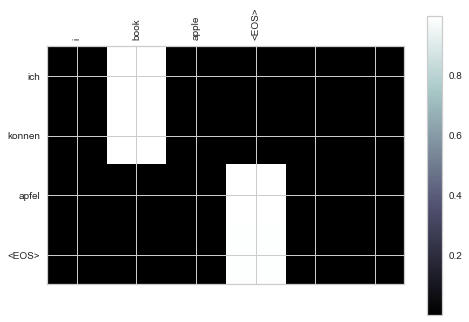

[[0.0007, 0.9, 0.001, 0.001, 0.001, 0.0002], [0.0002, 0.9, 0.001, 0.001, 0.0004, 0.0001], [0.0004, 0.002, 0.001, 0.9, 0.0009, 0.0003], [0.002, 0.0008, 0.002, 0.9, 0.002, 0.002]]
input = i apple book
output = ich essen apfel <EOS>


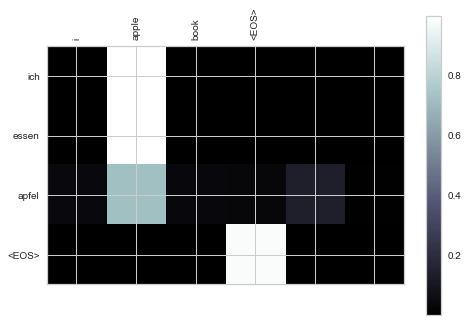

[[0.0008, 0.9, 0.0009, 0.001, 0.0008, 0.0003], [0.0002, 0.9, 0.0008, 0.001, 0.0004, 0.0001], [0.04, 0.7, 0.04, 0.03, 0.1, 0.01], [0.003, 0.001, 0.002, 0.9, 0.004, 0.002]]


In [44]:
attentions = evaluateAndShowAttention("i book apple")
print(format_floats(attentions.data.numpy()))
attentions = evaluateAndShowAttention("i apple book")
print(format_floats(attentions.data.numpy()))

input = we
output = wir trinken <EOS>


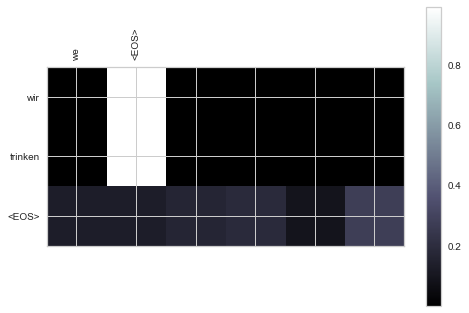

attentions torch.Size([5, 6])


tensor([[9.5817e-04, 9.9459e-01, 1.4044e-03, 2.1294e-03, 6.4340e-04, 2.7612e-04],
        [5.2344e-04, 9.9665e-01, 7.6006e-04, 1.2815e-03, 4.7598e-04, 3.1059e-04],
        [6.9081e-04, 3.2092e-03, 2.2508e-03, 9.9182e-01, 1.5506e-03, 4.7784e-04],
        [6.4781e-02, 2.4071e-02, 1.8429e-01, 3.4021e-01, 2.2929e-01, 1.5735e-01],
        [4.2307e-02, 1.4345e-02, 3.0504e-02, 2.5385e-02, 5.5595e-01, 3.3151e-01]])

In [45]:
evaluateAndShowAttention("we")

output_words, attentions = evaluate(encoder1, attn_decoder1, "we book")
print("attentions",attentions.shape)
attentions